In [1]:
import pandas as pd
import polars as pl
print(pl.__version__)
import json
import os

1.7.1


In [88]:
#This is the cell for functions

# Function to safely fetch points based on Place
def get_points(place, points_list):
    if 1 <= place <= len(points_list):
        return points_list[place - 1]
    return 0


In [ ]:
#Step One: Need to read in the necessary info, which in this case is M_chrono.csv
M_chrono = pl.read_csv('/Users/syverjohansen/ski/elo/python/ski/polars/excel365/men_chrono.csv')

#Step Two: Create a column called WC Points that maps place to world cup points from a list.  Also need to update for Tour de Ski and stage points
wc_points = [100,95,90,85,80,75,72,69,66,63,60,58,56,54,52,50,48,46,44,42,40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
stage_points = [50, 47, 44, 41, 38, 35, 32, 30, 28, 26, 24, 22, 20, 18, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
tds_points = [300, 285, 270, 255, 240, 216, 207, 198, 189, 180, 174, 168, 162, 156, 150, 144, 138, 132, 126, 120, 114, 108, 102, 96, 90, 84, 78, 72, 66, 60, 57, 54, 51, 48, 45, 42, 39, 36, 33, 30, 27, 24, 21, 18, 15, 12, 9, 6, 3]
df = M_chrono

# Apply points logic based on Event and Distance
df = df.with_columns(
    pl.when((pl.col("Event") == "Tour de Ski") & (pl.col("Distance") == "Stage"))
      .then(pl.col("Place").map_elements(lambda place: get_points(place, tds_points)))
      .when(pl.col("Event") == "Tour de Ski")
      .then(pl.col("Place").map_elements(lambda place: get_points(place, stage_points)))
      .otherwise(pl.col("Place").map_elements(lambda place: get_points(place, wc_points)))
      .alias("Points")
)

#Sort the df by Date and then by Race, to get it in the order we want
df = df.sort(["Date", "Race", "Place"])


#Step Three: Get points for each season to use as the dependent variable.  Need to use a cumsum function and the total should be in the 
#summer value

#First, we want to only have seasons in the last five years, since that is what we consider "modern" for skiing.
#
#Maybe we can increase that value to 10 or more based on the results
df = df.filter(pl.col("Season") > 2018)
df = df.filter(pl.col("Event").is_in(["Offseason", "World Cup", "Nordic Opening", "Tour de Ski"]))


#Now we can cumsum over the seasons to get the total number of points.  This will be the dependent variable in all of our work
df = df.with_columns(
    pl.col("Points").cum_sum().over(["ID", "Season"]).alias("Cumulative_Points")
)
first_place = df.filter(pl.col("Place")==1)
max_points_per_season = first_place.group_by("Season").agg(pl.col("Points").sum().alias("Max_Points"))
df = df.join(max_points_per_season, on ="Season")
df = df.with_columns(
    (pl.col("Cumulative_Points") / pl.col("Max_Points")).alias("Pct_of_Max_Points")
)



save_df = df

#Step Four: Set up the explanatory variables.  We want to take the ending elo score from the previous season and use that data to predict
#the points in the next season


#To start, we only want the offseason, since that's where our x and y are going to come from
df = df.filter(pl.col("Event") == "Offseason")

#Sort the DataFrame by skier ID and season, so that IDs will match between the seasons
df = df.sort(["ID", "Season"])

#Shift the Pelo column within each skier's data to represent the previous season's Pelo
df = df.with_columns([
    pl.col("Pelo").shift(1).over("ID").alias("Prev_Pelo")
])

df = df.with_columns([
    pl.col("Distance_Pelo").shift(1).over("ID").alias("Prev_Distance")
])

df = df.with_columns([
    pl.col("Sprint_Pelo").shift(1).over("ID").alias("Prev_Sprint")
])

#Filter out rows where Prev_Pelo is null (e.g., first appearance of each skier)
df = df.filter(pl.col("Prev_Pelo").is_not_null())



df = df.with_columns(
    pl.when(pl.col("Age") == "None")
    .then(None)
    .otherwise(pl.col("Age"))
    .alias("Age")
)
df = df.with_columns(
    pl.col("Age").cast(pl.Float64)
)
df = df.filter(pl.col("Age").is_not_null())


distance_df = df.filter(pl.col("Prev_Distance").is_not_null())
sprint_df = df.filter(pl.col("Prev_Sprint").is_not_null())
both_df = sprint_df.filter(pl.col("Prev_Distance").is_not_null())
print(both_df)

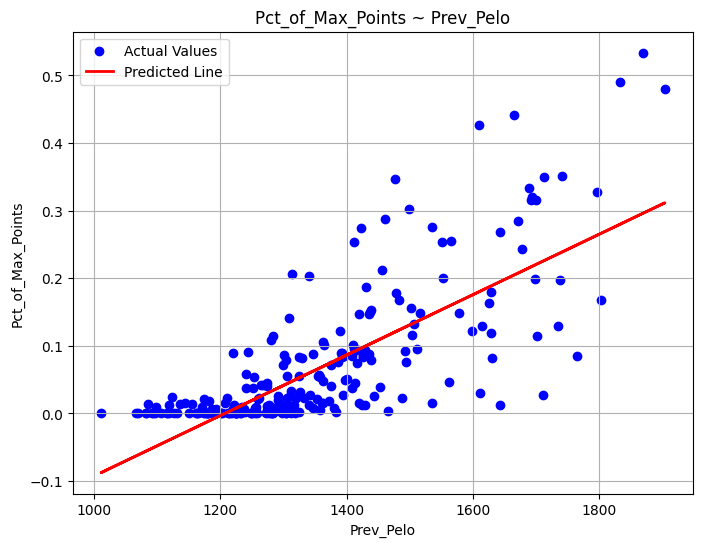

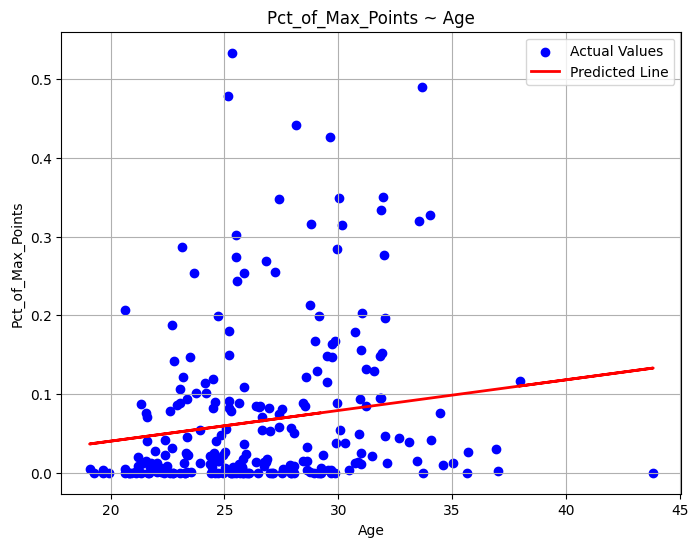

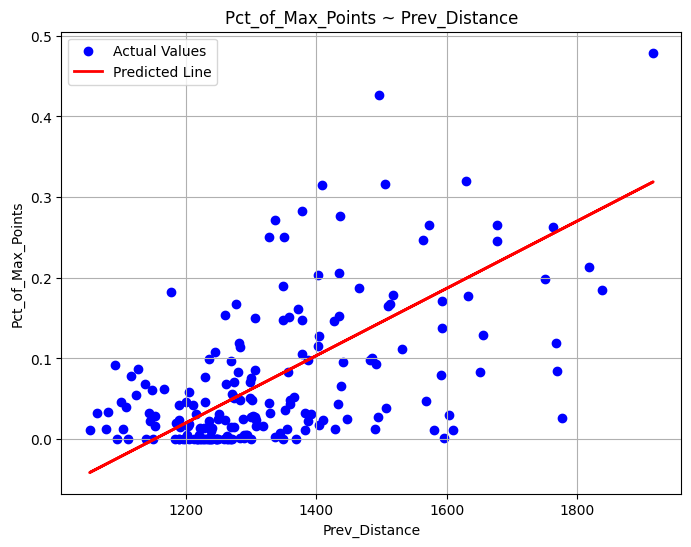

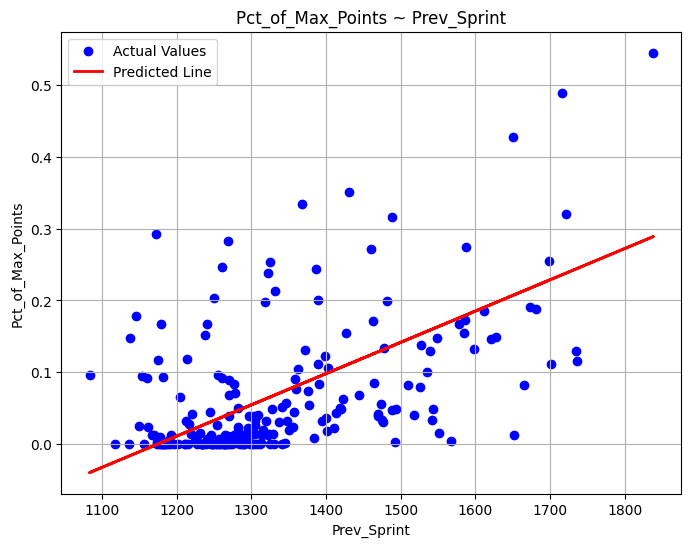

(879, 2) (879,)


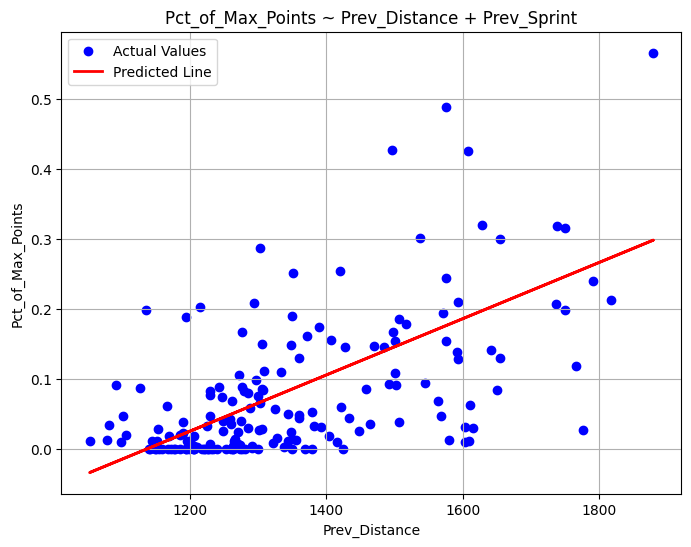

In [156]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the variables
# You might need to convert Polars DataFrame to NumPy as needed

def create_and_plot_model(X, y, X_label, y_label, title):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual Values')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Line')
    plt.xlabel(X_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare y (Pct_of_Max_Points)
y = df.select("Pct_of_Max_Points").to_numpy().ravel()

# Model 1: Pct_of_Max_Points ~ Prev_Pelo
X_pelo = df.select("Prev_Pelo").to_numpy()
create_and_plot_model(X_pelo, y, "Prev_Pelo", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Pelo")


# Model 1: Pct_of_Max_Points ~ Prev_Pelo
X_age = df.select("Age").to_numpy()
create_and_plot_model(X_age, y, "Age", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Age")

# Model 2: Pct_of_Max_Points ~ Prev_Distance
y_distance = distance_df.select("Pct_of_Max_Points").to_numpy().ravel()
X_distance = distance_df.select("Prev_Distance").to_numpy()
create_and_plot_model(X_distance, y_distance, "Prev_Distance", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Distance")

# Model 3: Pct_of_Max_Points ~ Prev_Sprint
y_sprint = sprint_df.select("Pct_of_Max_Points").to_numpy().ravel()
X_sprint = sprint_df.select("Prev_Sprint").to_numpy()
create_and_plot_model(X_sprint, y_sprint, "Prev_Sprint", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Sprint")

df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Now select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)
# Reshape X_both[:, 0] to 2D
X_both_distance = X_both[:, 0].reshape(-1, 1)

# Now proceed with the modeling and plotting
create_and_plot_model(X_both_distance, y_both, "Prev_Distance", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint")



Model Summary for Pct_of_Max_Points ~ Prev_Pelo
Intercept: -0.5395701719807374
Coefficients: [0.00044684]

Custom R^2 (Train) for Pct_of_Max_Points ~ Prev_Pelo: 0.6490569169419281
Custom R^2 (Test) for Pct_of_Max_Points ~ Prev_Pelo: 0.6661325331751133



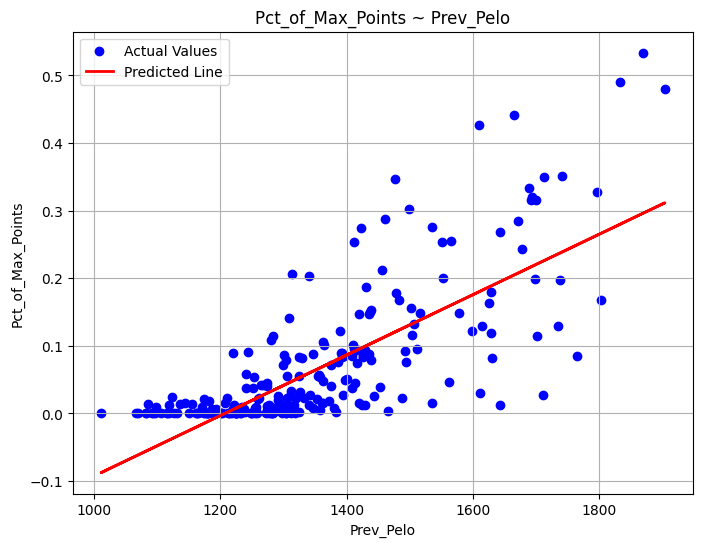

Model Summary for Pct_of_Max_Points ~ Prev_Distance
Intercept: -0.4804098069356313
Coefficients: [0.00041714]

Custom R^2 (Train) for Pct_of_Max_Points ~ Prev_Distance: 0.5585068095189789
Custom R^2 (Test) for Pct_of_Max_Points ~ Prev_Distance: 0.5066423930667598



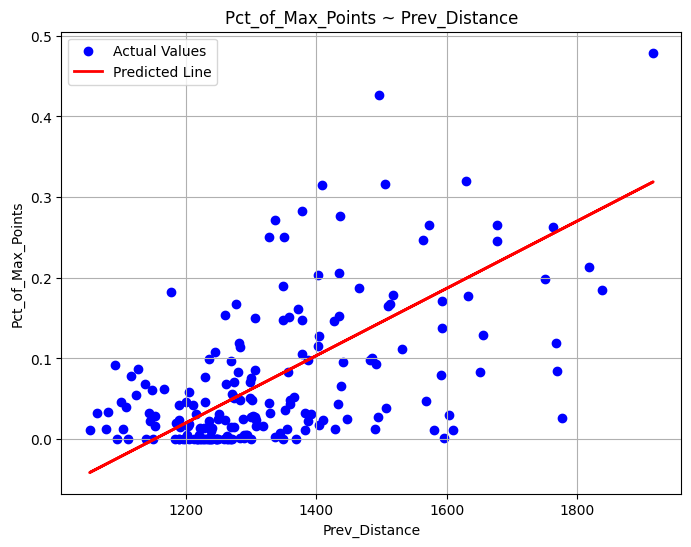

Model Summary for Pct_of_Max_Points ~ Prev_Sprint
Intercept: -0.5119012593615514
Coefficients: [0.00043554]

Custom R^2 (Train) for Pct_of_Max_Points ~ Prev_Sprint: 0.4572414421918417
Custom R^2 (Test) for Pct_of_Max_Points ~ Prev_Sprint: 0.43113784959389967



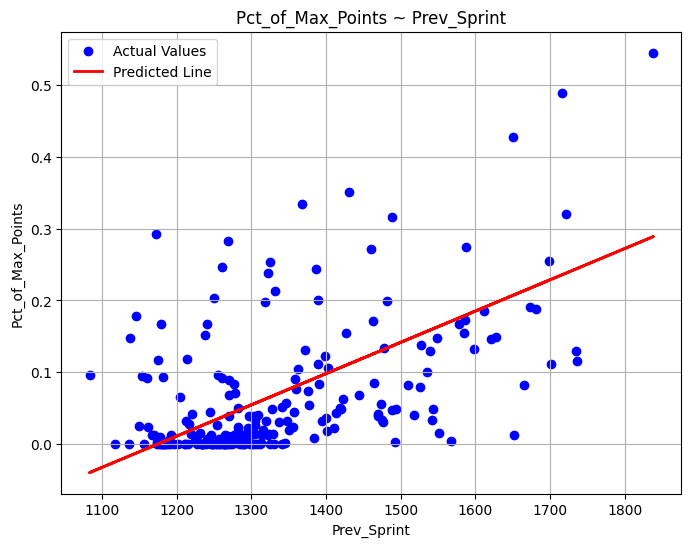

(879, 2) (879,)
Model Summary for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint
Intercept: -0.4567169442674013
Coefficients: [0.00040162]

Custom R^2 (Train) for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.5475664998761867
Custom R^2 (Test) for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.5118512668248594



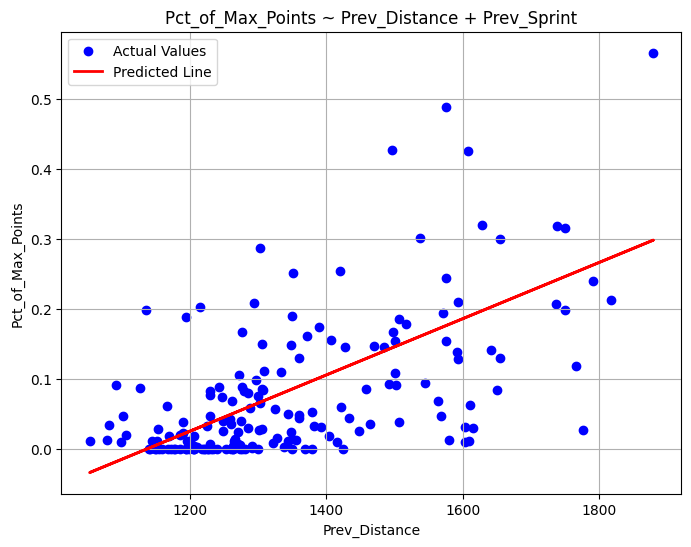

In [125]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate and print summary statistics, custom residuals, and plot
# Function to calculate and print summary statistics, custom residuals, and plot
def create_and_plot_model(X, y, X_label, y_label, title):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    print(f"Coefficients: {model.coef_}\n")

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # using Pct_of_Max_Points as the weight
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # using Pct_of_Max_Points as the weight
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual Values')
    plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Predicted Line')
    plt.xlabel(X_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Prepare y (Pct_of_Max_Points)
y = df.select("Pct_of_Max_Points").to_numpy().ravel()

# Model 1: Pct_of_Max_Points ~ Prev_Pelo
X_pelo = df.select("Prev_Pelo").to_numpy()
create_and_plot_model(X_pelo, y, "Prev_Pelo", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Pelo")

# Model 2: Pct_of_Max_Points ~ Age
#X_age = df.select("Age").to_numpy()
#create_and_plot_model(X_age, y, "Age", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Age")

# Model 3: Pct_of_Max_Points ~ Prev_Distance
y_distance = distance_df.select("Pct_of_Max_Points").to_numpy().ravel()
X_distance = distance_df.select("Prev_Distance").to_numpy()
create_and_plot_model(X_distance, y_distance, "Prev_Distance", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Distance")

# Model 4: Pct_of_Max_Points ~ Prev_Sprint
y_sprint = sprint_df.select("Pct_of_Max_Points").to_numpy().ravel()
X_sprint = sprint_df.select("Prev_Sprint").to_numpy()
create_and_plot_model(X_sprint, y_sprint, "Prev_Sprint", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Sprint")

# Model 5: Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Now select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)
# Reshape X_both[:, 0] to 2D
X_both_distance = X_both[:, 0].reshape(-1, 1)

# Now proceed with the modeling and plotting
create_and_plot_model(X_both_distance, y_both, "Prev_Distance", "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint")


(879, 2) (879,)
Model Summary for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint
Intercept: -0.7473463412937029
Coefficient for Prev_Distance: 0.00032194555693484175
Coefficient for Prev_Sprint: 0.00029608683574864665

Custom R^2 (Train) for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.7123694893750652
Custom R^2 (Test) for Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.7153434188335324



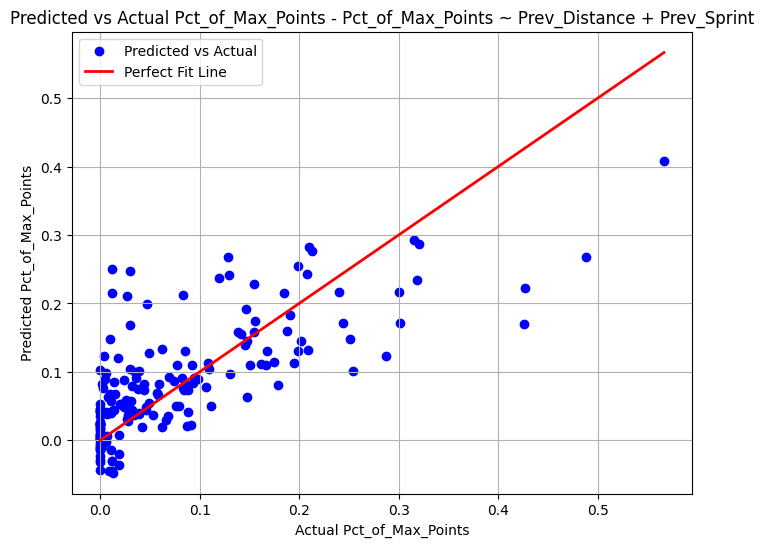

In [126]:
##This one is for predicting predicted vs actual so we can do multiple regression
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual
def create_and_plot_model(X, y, X_labels, y_label, title):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for {X_labels[i]}: {coef}")
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # using Pct_of_Max_Points as the weight
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # using Pct_of_Max_Points as the weight
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with multiple features (Prev_Distance and Prev_Sprint)
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for multiple regression
create_and_plot_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint")


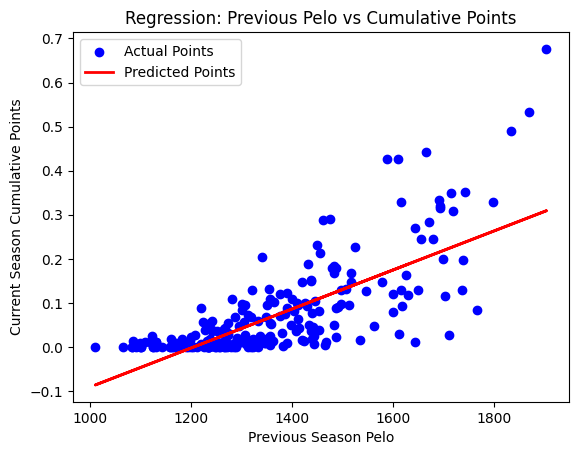

Intercept: -0.5339243243044577
Coefficients: [0.00044294]
R-squared: 0.5699352022535459
Mean Squared Error (MSE): 0.005030683383030194
Root Mean Squared Error (RMSE): 0.07092731055827645


In [60]:
#First go at a model is just prev_pelo and 

#Step Five: Now we want to build the regression model using Prev_Pelo as our explanatory and Cumulative_Points as our dependent
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming the DataFrame `df` is already prepared with columns "Prev_Pelo" and "Cumulative_Points"

# Step 1: Prepare the data for regression
# Define X (Prev_Pelo) and y (Cumulative_Points)
X = df.select("Prev_Pelo").to_numpy()  # Features
y = df.select("Pct_of_Max_Points").to_numpy().ravel()  # Target

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Get predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual Points')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Points')
plt.xlabel("Previous Season Pelo")
plt.ylabel("Current Season Cumulative Points")
plt.title("Regression: Previous Pelo vs Cumulative Points")
plt.legend()
plt.show()


print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
r_squared = model.score(X_test, y_test)
print("R-squared:", r_squared)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
#This plot has major heteroscedasticity where the residuals increase as the predictor-variable increases

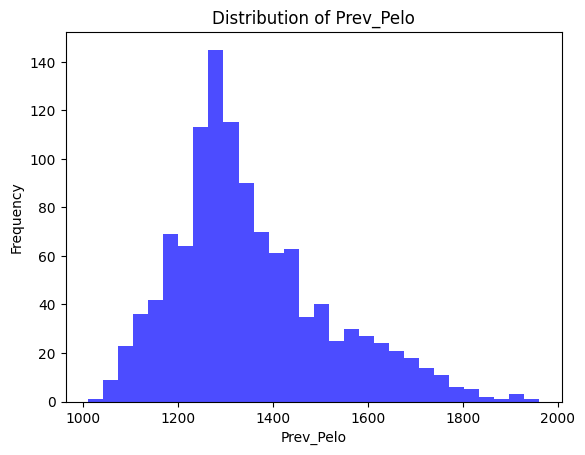

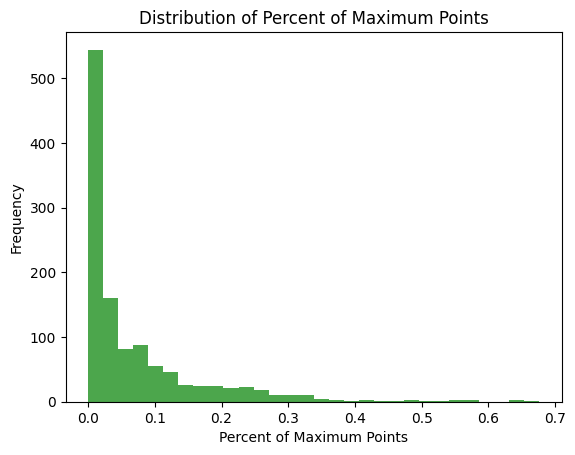

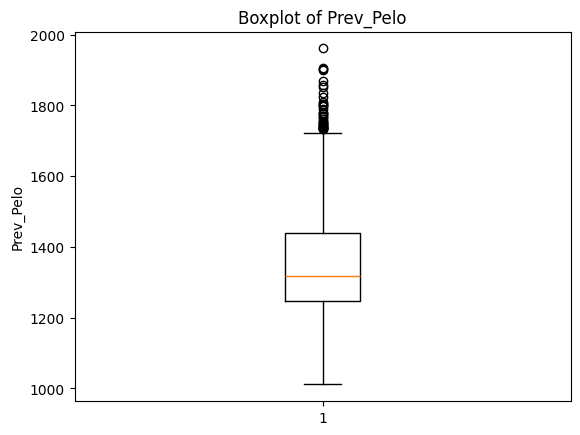

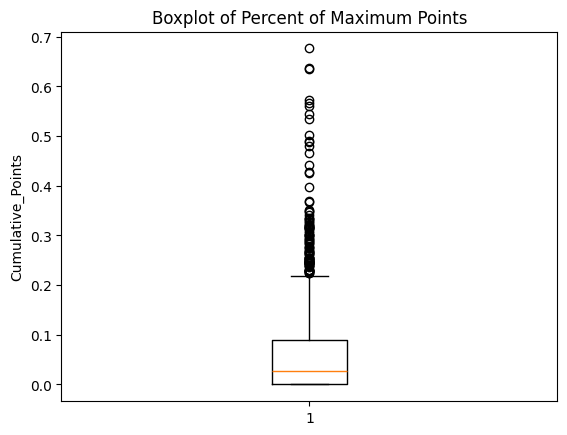

Skewness of Prev_Pelo: [0.82976312]
Skewness of Cumulative_Points: [2.39493639]


In [61]:
# Histogram for Prev_Pelo
plt.hist(df.select("Prev_Pelo").to_numpy(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Prev_Pelo')
plt.xlabel('Prev_Pelo')
plt.ylabel('Frequency')
plt.show()

# Histogram for Cumulative_Points
plt.hist(df.select("Pct_of_Max_Points").to_numpy(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Percent of Maximum Points')
plt.xlabel('Percent of Maximum Points')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Prev_Pelo
plt.boxplot(df.select("Prev_Pelo").to_numpy())
plt.title('Boxplot of Prev_Pelo')
plt.ylabel('Prev_Pelo')
plt.show()

# Boxplot for Cumulative_Points
plt.boxplot(df.select("Pct_of_Max_Points").to_numpy())
plt.title('Boxplot of Percent of Maximum Points')
plt.ylabel('Cumulative_Points')
plt.show()

from scipy.stats import skew

# For a specific column, e.g., Prev_Pelo
prev_pelo_values = df.select("Prev_Pelo").to_numpy()

# Calculate skewness
skewness_prev_pelo = skew(prev_pelo_values)
print(f"Skewness of Prev_Pelo: {skewness_prev_pelo}")

# For Cumulative_Points
cumulative_points_values = df.select("Pct_of_Max_Points").to_numpy()
skewness_cumulative_points = skew(cumulative_points_values)
print(f"Skewness of Cumulative_Points: {skewness_cumulative_points}")


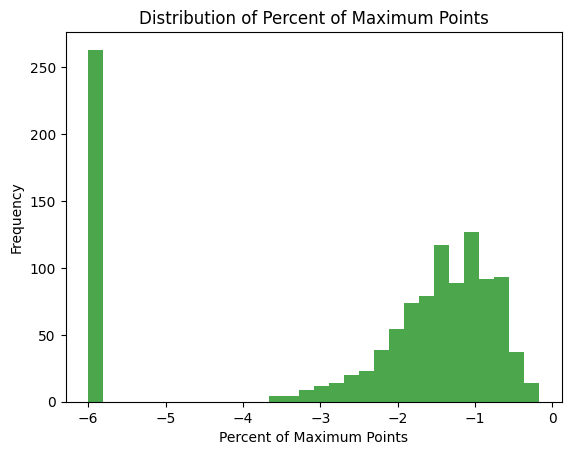

Skewness of Cumulative_Points: [-1.04698528]


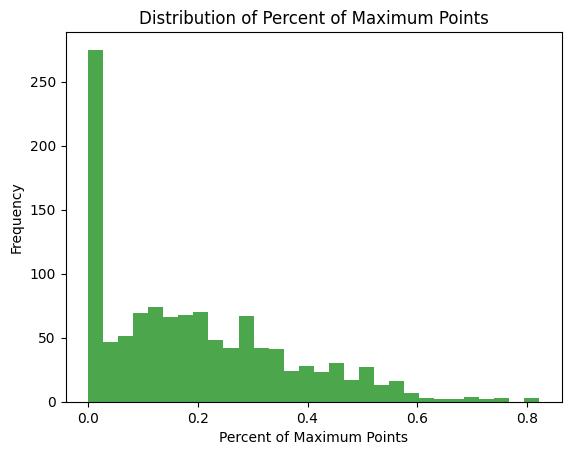

Skewness of Cumulative_Points: [0.79901639]


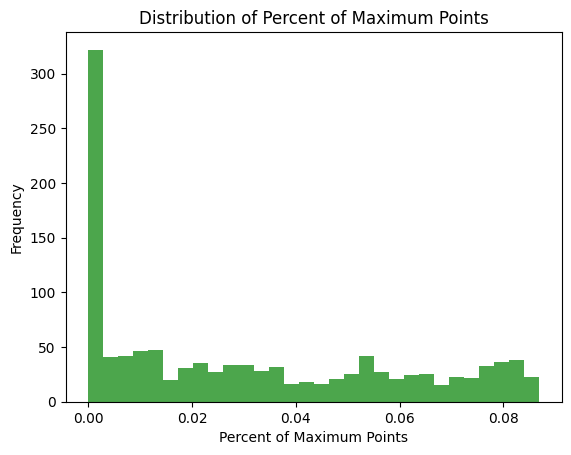

Skewness of Cumulative_Points: [0.51133058]


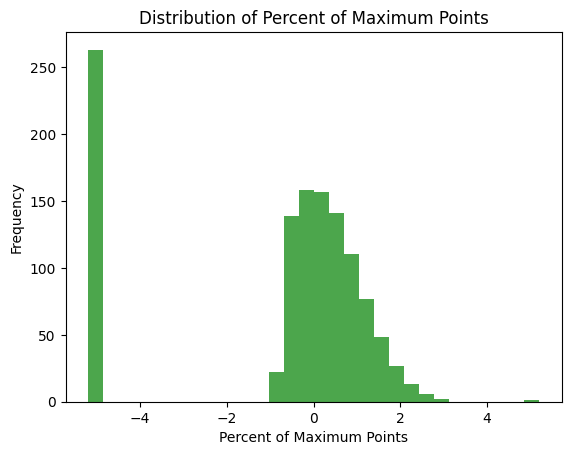

Skewness of Cumulative_Points: [-1.0262567]


In [62]:
epsilon = 1e-6  # Small constant to avoid log(0)
df = df.with_columns([
    (pl.col("Pct_of_Max_Points") + epsilon).log10().alias("Log_Pct_of_Max_Points")
])

# Histogram for Cumulative_Points
plt.hist(df.select("Log_Pct_of_Max_Points").to_numpy(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Percent of Maximum Points')
plt.xlabel('Percent of Maximum Points')
plt.ylabel('Frequency')
plt.show()

# For Cumulative_Points
cumulative_points_values = df.select("Log_Pct_of_Max_Points").to_numpy()
skewness_cumulative_points = skew(cumulative_points_values)
print(f"Skewness of Cumulative_Points: {skewness_cumulative_points}")


df = df.with_columns([
    pl.col("Pct_of_Max_Points").sqrt().alias("Sqrt_Pct_of_Max_Points")
])
plt.hist(df.select("Sqrt_Pct_of_Max_Points").to_numpy(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Percent of Maximum Points')
plt.xlabel('Percent of Maximum Points')
plt.ylabel('Frequency')
plt.show()
# For Cumulative_Points
cumulative_points_values = df.select("Sqrt_Pct_of_Max_Points").to_numpy()
skewness_cumulative_points = skew(cumulative_points_values)
print(f"Skewness of Cumulative_Points: {skewness_cumulative_points}")



from scipy import stats
df = df.with_columns([
    pl.Series(stats.boxcox(df["Pct_of_Max_Points"] + 1)[0]).alias("BoxCox_Cumulative_Points")
])
plt.hist(df.select("BoxCox_Cumulative_Points").to_numpy(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Percent of Maximum Points')
plt.xlabel('Percent of Maximum Points')
plt.ylabel('Frequency')
plt.show()
# For Cumulative_Points
cumulative_points_values = df.select("BoxCox_Cumulative_Points").to_numpy()
skewness_cumulative_points = skew(cumulative_points_values)
print(f"Skewness of Cumulative_Points: {skewness_cumulative_points}")


from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
df = df.with_columns([
    pl.Series(qt.fit_transform(df["Pct_of_Max_Points"].to_numpy().reshape(-1, 1)).ravel()).alias("Quantile_Cumulative_Points")
])
plt.hist(df.select("Quantile_Cumulative_Points").to_numpy(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Percent of Maximum Points')
plt.xlabel('Percent of Maximum Points')
plt.ylabel('Frequency')
plt.show()
# For Cumulative_Points
cumulative_points_values = df.select("Quantile_Cumulative_Points").to_numpy()
skewness_cumulative_points = skew(cumulative_points_values)
print(f"Skewness of Cumulative_Points: {skewness_cumulative_points}")


In [63]:
# Count total rows in the dataframe
total_rows = df.height

# Count rows where Pct_of_Max_Points is zero
zero_pct_rows = df.filter(pl.col("Pct_of_Max_Points") == 0).height

# Calculate the proportion
proportion_zero = zero_pct_rows / total_rows
print(f"Proportion of Pct_of_Max_Points equal to zero: {proportion_zero:.2%}")


Proportion of Pct_of_Max_Points equal to zero: 22.59%


(879, 2) (879,)
Model Summary for log(Pct_of_Max_Points) ~ Prev_Pelo
Intercept: -9.756788890206998
Coefficient for log(Prev_Pelo): 0.005655630364986449

Custom R^2 (Train) for log(Pct_of_Max_Points) ~ Prev_Pelo: 0.2952309126628291
Custom R^2 (Test) for log(Pct_of_Max_Points) ~ Prev_Pelo: 0.28814617245563257



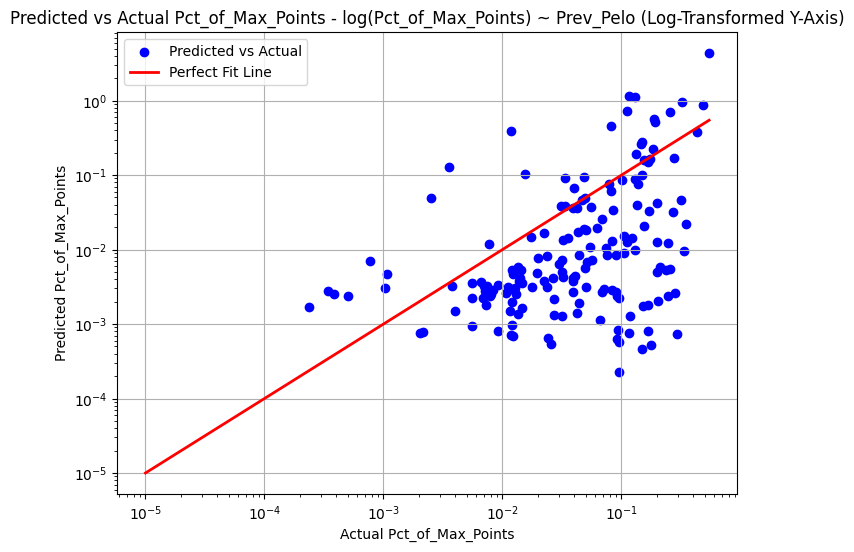

Model Summary for log(Pct_of_Max_Points) ~ Prev_Distance
Intercept: -9.756788890206998
Coefficient for log(Prev_Distance): 0.005655630364986449

Custom R^2 (Train) for log(Pct_of_Max_Points) ~ Prev_Distance: 0.2952309126628291
Custom R^2 (Test) for log(Pct_of_Max_Points) ~ Prev_Distance: 0.28814617245563257



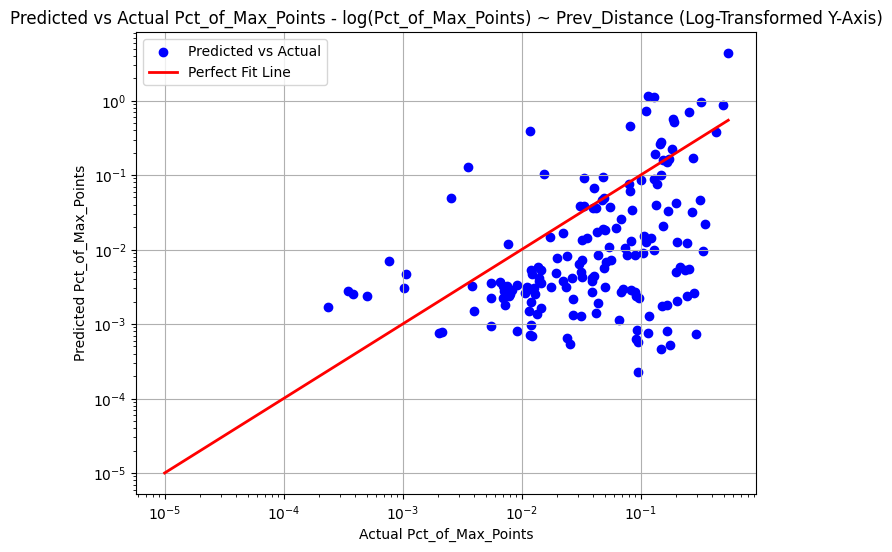

Model Summary for log(Pct_of_Max_Points) ~ Prev_Sprint
Intercept: -9.756788890206998
Coefficient for log(Prev_Sprint): 0.005655630364986449

Custom R^2 (Train) for log(Pct_of_Max_Points) ~ Prev_Sprint: 0.2952309126628291
Custom R^2 (Test) for log(Pct_of_Max_Points) ~ Prev_Sprint: 0.28814617245563257



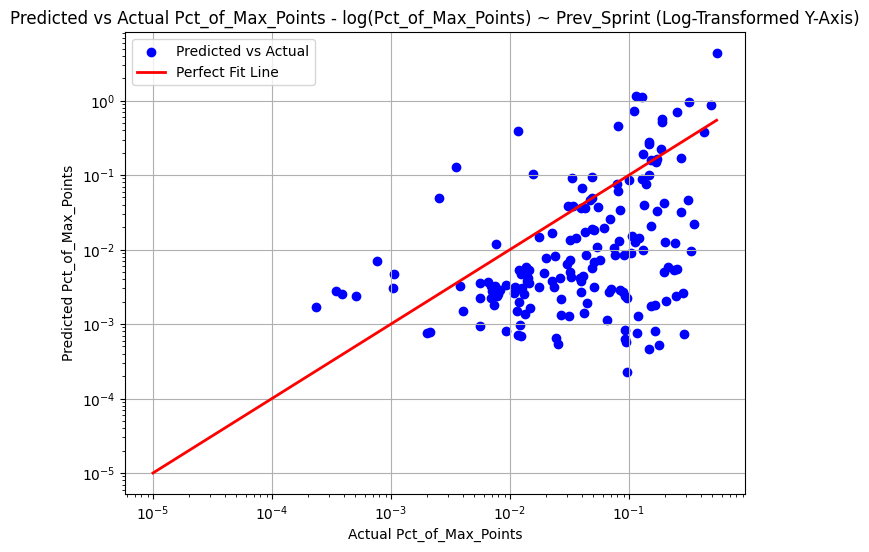

Model Summary for log(Pct_of_Max_Points) ~ Prev_Distance + log(Prev_Sprint)
Intercept: -11.724224224815368
Coefficient for log(Prev_Distance): 0.0034900890941973765
Coefficient for log(Prev_Sprint): 0.0037293855138417794

Custom R^2 (Train) for log(Pct_of_Max_Points) ~ Prev_Distance + log(Prev_Sprint): 0.42653928409127695
Custom R^2 (Test) for log(Pct_of_Max_Points) ~ Prev_Distance + log(Prev_Sprint): 0.3915465396865644



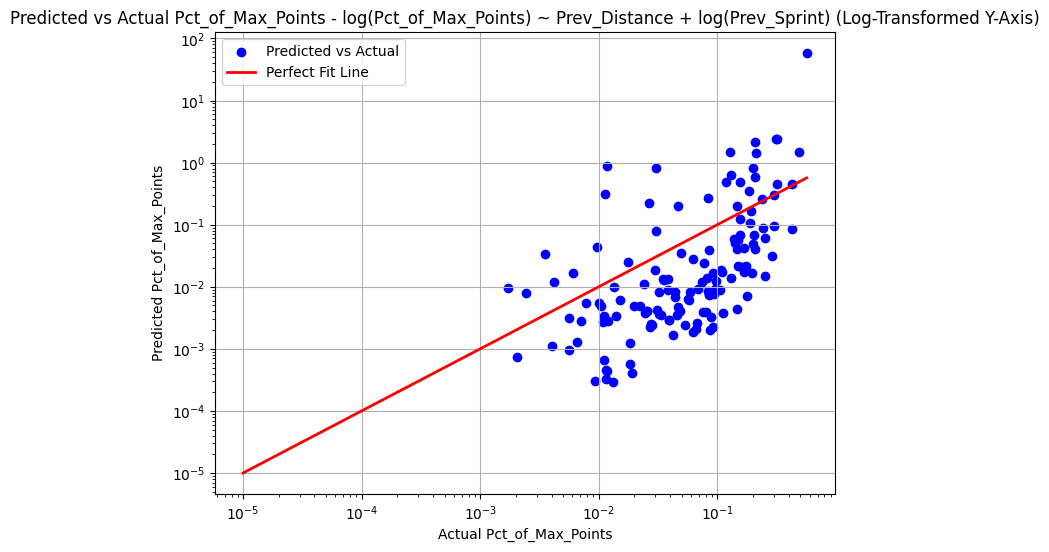

In [133]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for log regression
def create_and_plot_log_model(X, y, X_labels, y_label, title, log_base=10, epsilon=1e-5):
    # Log-transform the target variable (y) with log base 10
    y_log = np.log10(y + epsilon)

    # Log-transform the explanatory variables (features) with log base 10
    #X_log = np.log10(X + 1)  # Adding 1 to avoid log(0) issues for X, adjust if needed
    X_log = X
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for log({X_labels[i]}): {coef}")
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using log-transformed Pct_of_Max_Points
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using log-transformed Pct_of_Max_Points
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values on log y-axis
    plt.figure(figsize=(8, 6))
    plt.scatter(10**y_test - epsilon, 10**y_pred_test - epsilon, color='blue', label='Predicted vs Actual')
    plt.plot([10**y_test.min(), 10**y_test.max()], [10**y_test.min(), 10**y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (Log-Transformed Y-Axis)")
    plt.legend()
    plt.grid(True)
    plt.show()

X_elo = df.select(["Prev_Pelo"]).to_numpy()
X_distance = distance_df.select(["Prev_Distance"]).to_numpy()
X_sprint = sprint_df.select(["Prev_Sprint"]).to_numpy()

y_elo = df.select("Pct_of_Max_Points").to_numpy().ravel()
y_distance = distance_df.select("Pct_of_Max_Points").to_numpy().ravel()
y_sprint = sprint_df.select("Pct_of_Max_Points").to_numpy().ravel()


# Example usage with log-transformed multiple features (Prev_Distance and Prev_Sprint)
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for multiple regression with log-transformed y-axis
create_and_plot_log_model(X_sprint, y_sprint, ["Prev_Pelo"], "Pct_of_Max_Points", "log(Pct_of_Max_Points) ~ Prev_Pelo")
create_and_plot_log_model(X_sprint, y_sprint, ["Prev_Distance"], "Pct_of_Max_Points", "log(Pct_of_Max_Points) ~ Prev_Distance")
create_and_plot_log_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "log(Pct_of_Max_Points) ~ Prev_Sprint")
create_and_plot_log_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "log(Pct_of_Max_Points) ~ Prev_Distance + log(Prev_Sprint)")


(879, 2) (879,)
Model Summary for Weighted: Pct_of_Max_Points ~ Prev_Pelo
Intercept: -0.5395701719807374
Coefficient for Prev_Pelo: 0.00044684089744286216

Custom R² (Train) for Weighted: Pct_of_Max_Points ~ Prev_Pelo: 0.35801982277791644
Custom R² (Test) for Weighted: Pct_of_Max_Points ~ Prev_Pelo: 0.29021263155033417



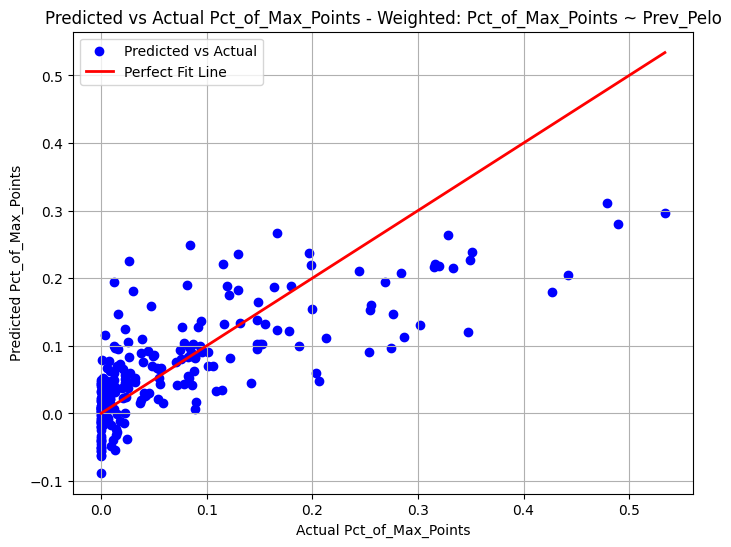

Model Summary for Weighted: Pct_of_Max_Points ~ Prev_Distance
Intercept: -0.4804098069356313
Coefficient for Prev_Distance: 0.00041713553858018995

Custom R² (Train) for Weighted: Pct_of_Max_Points ~ Prev_Distance: 0.1689916145542032
Custom R² (Test) for Weighted: Pct_of_Max_Points ~ Prev_Distance: 0.04435604812654936



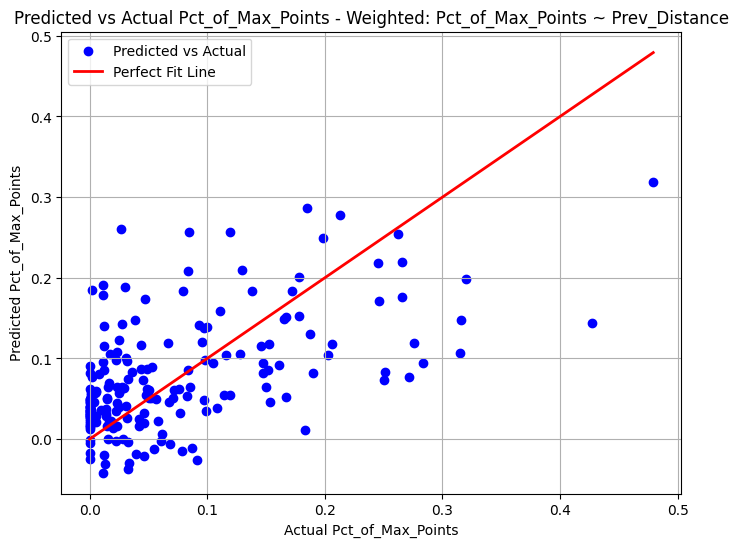

Model Summary for Weighted: Pct_of_Max_Points ~ Prev_Sprint
Intercept: -0.5119012593615514
Coefficient for Prev_Sprint: 0.0004355446009417612

Custom R² (Train) for Weighted: Pct_of_Max_Points ~ Prev_Sprint: -0.013446577855545039
Custom R² (Test) for Weighted: Pct_of_Max_Points ~ Prev_Sprint: -0.12668677990045873



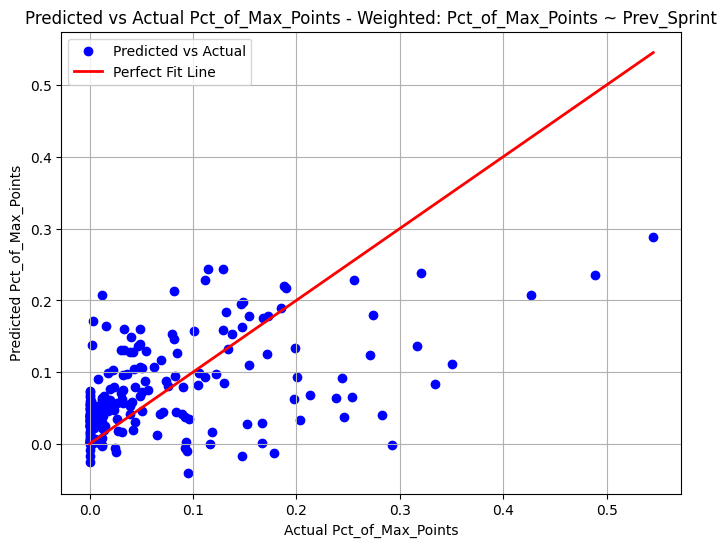

Model Summary for Weighted: Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint
Intercept: -0.7473463412937029
Coefficient for Prev_Distance: 0.00032194555693484175
Coefficient for Prev_Sprint: 0.00029608683574864665

Custom R² (Train) for Weighted: Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.4675581081770104
Custom R² (Test) for Weighted: Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint: 0.46327615367457287



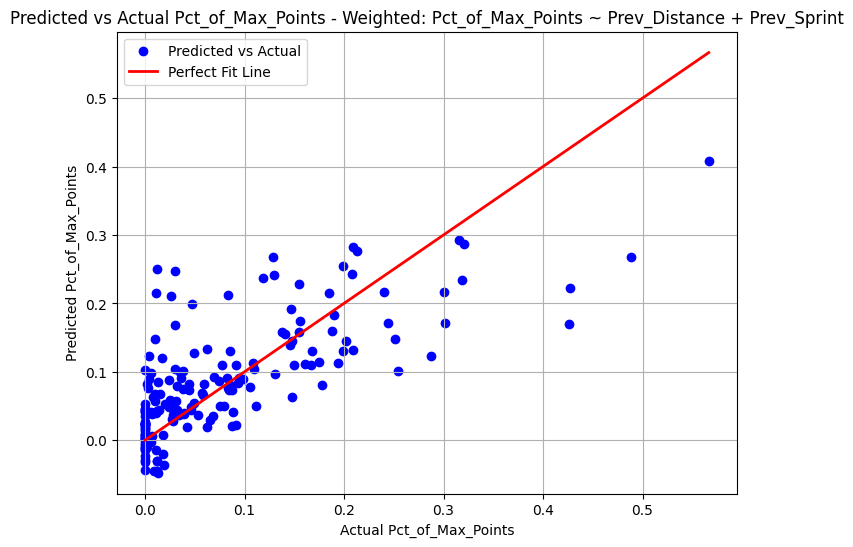

In [135]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for weighted regression
def create_and_plot_weighted_model(X, y, X_labels, y_label, title):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model (no need for weight application during training)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for {X_labels[i]}: {coef}")
    print()

    # Custom R² calculation with residuals weighted by Pct_of_Max_Points (y)
    def custom_r2_weighted(y_true, y_pred):
        residuals = y_true - y_pred
        weights = y_true  # Use Pct_of_Max_Points as the weights
        weighted_rss = np.sum(weights * residuals ** 2)
        weighted_tss = np.sum(weights * (y_true - np.average(y_true, weights=weights)) ** 2)
        return 1 - (weighted_rss / weighted_tss)

    # Calculate custom R² scores for train and test sets
    custom_r2_train = custom_r2_weighted(y_train, y_pred_train)
    custom_r2_test = custom_r2_weighted(y_test, y_pred_test)

    # Print the custom R² scores
    print(f"Custom R² (Train) for {title}: {custom_r2_train}")
    print(f"Custom R² (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with your data
X_elo = df.select(["Prev_Pelo"]).to_numpy()
X_distance = distance_df.select(["Prev_Distance"]).to_numpy()
X_sprint = sprint_df.select(["Prev_Sprint"]).to_numpy()

y_elo = df.select("Pct_of_Max_Points").to_numpy().ravel()
y_distance = distance_df.select("Pct_of_Max_Points").to_numpy().ravel()
y_sprint = sprint_df.select("Pct_of_Max_Points").to_numpy().ravel()

# Example usage with multiple features (Prev_Distance and Prev_Sprint)
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for weighted regression
create_and_plot_weighted_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "Weighted: Pct_of_Max_Points ~ Prev_Pelo")
create_and_plot_weighted_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "Weighted: Pct_of_Max_Points ~ Prev_Distance")
create_and_plot_weighted_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "Weighted: Pct_of_Max_Points ~ Prev_Sprint")
create_and_plot_weighted_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Weighted: Pct_of_Max_Points ~ Prev_Distance + Prev_Sprint")


(879, 2) (879,)
Model Summary for sqrt(Pct_of_Max_Points) ~ Prev_Pelo
Intercept: -0.9399086879939635
Coefficient for sqrt(Prev_Pelo): 0.000835896797210065

Custom R^2 (Train) for sqrt(Pct_of_Max_Points) ~ Prev_Pelo: 0.7142950312514099
Custom R^2 (Test) for sqrt(Pct_of_Max_Points) ~ Prev_Pelo: 0.6920585991715323



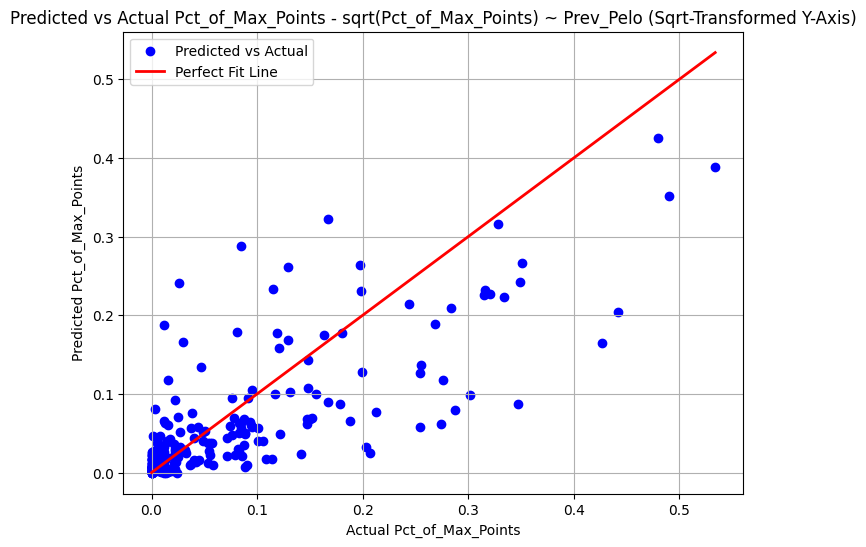

Model Summary for sqrt(Pct_of_Max_Points) ~ Prev_Distance
Intercept: -0.7348010307186672
Coefficient for sqrt(Prev_Distance): 0.0007080400604453105

Custom R^2 (Train) for sqrt(Pct_of_Max_Points) ~ Prev_Distance: 0.5470845874338135
Custom R^2 (Test) for sqrt(Pct_of_Max_Points) ~ Prev_Distance: 0.365084150183868



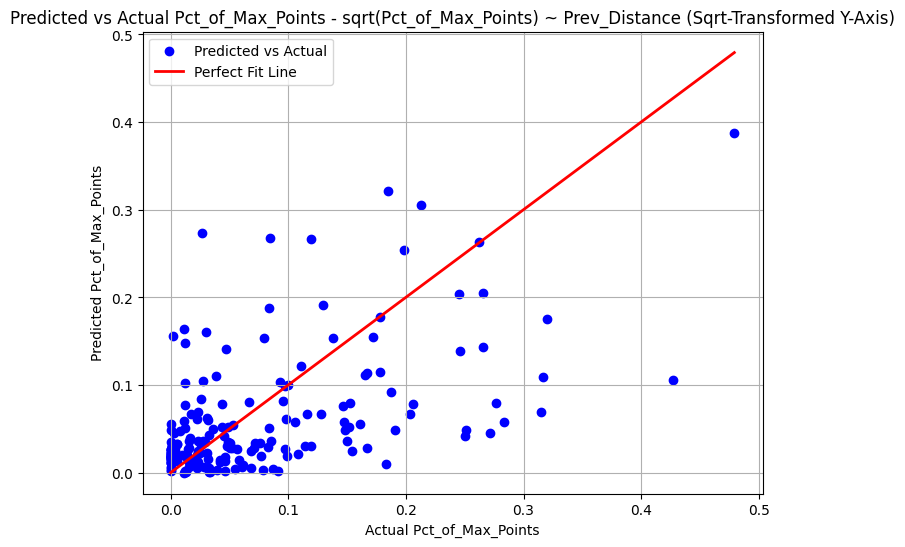

Model Summary for sqrt(Pct_of_Max_Points) ~ Prev_Sprint
Intercept: -0.8343971394300916
Coefficient for sqrt(Prev_Sprint): 0.0007737104262888623

Custom R^2 (Train) for sqrt(Pct_of_Max_Points) ~ Prev_Sprint: 0.43657076029262387
Custom R^2 (Test) for sqrt(Pct_of_Max_Points) ~ Prev_Sprint: 0.33526111086014054



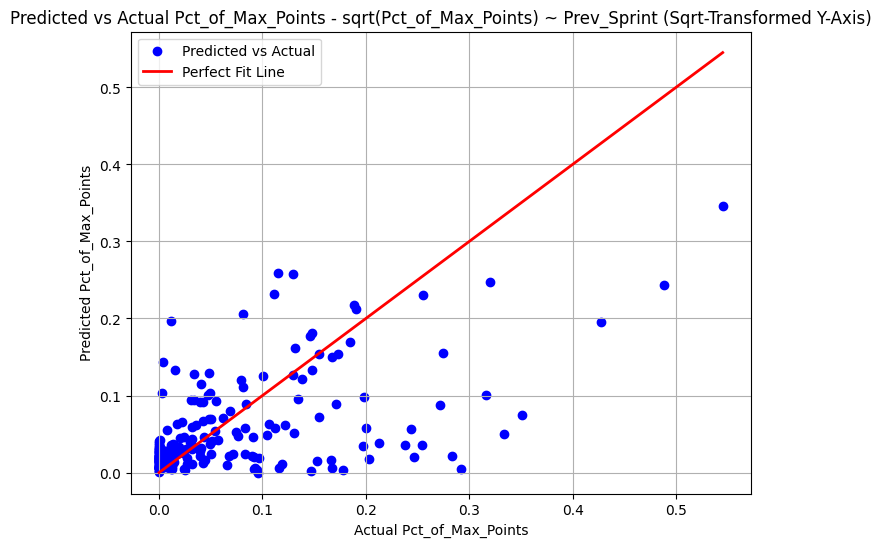

Model Summary for sqrt(Pct_of_Max_Points) ~ Prev_Distance + sqrt(Prev_Sprint)
Intercept: -1.2011076847270346
Coefficient for sqrt(Prev_Distance): 0.0005387703244934623
Coefficient for sqrt(Prev_Sprint): 0.000521607006317777

Custom R^2 (Train) for sqrt(Pct_of_Max_Points) ~ Prev_Distance + sqrt(Prev_Sprint): 0.7049297802289218
Custom R^2 (Test) for sqrt(Pct_of_Max_Points) ~ Prev_Distance + sqrt(Prev_Sprint): 0.6759350752235671



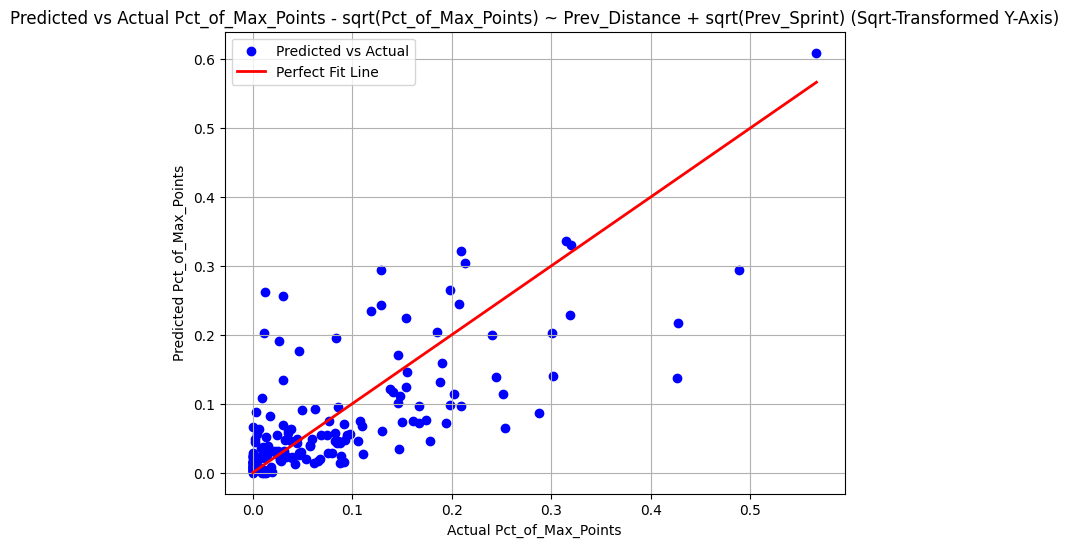

In [137]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for sqrt regression
def create_and_plot_sqrt_model(X, y, X_labels, y_label, title, epsilon=1e-5):
    # Square root transform the target variable (y), adding epsilon to avoid sqrt(0)
    y_sqrt = np.sqrt(y + epsilon)

    # Square root transform the explanatory variables (features) with sqrt
    X_sqrt = X
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_sqrt, y_sqrt, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for sqrt({X_labels[i]}): {coef}")
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using sqrt-transformed Pct_of_Max_Points
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using sqrt-transformed Pct_of_Max_Points
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values on sqrt y-axis
    plt.figure(figsize=(8, 6))
    plt.scatter((y_test ** 2) - epsilon, (y_pred_test ** 2) - epsilon, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min()**2, y_test.max()**2], [y_test.min()**2, y_test.max()**2], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (Sqrt-Transformed Y-Axis)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with sqrt-transformed multiple features (Prev_Distance and Prev_Sprint)
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for multiple regression with sqrt-transformed y-axis
create_and_plot_sqrt_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "sqrt(Pct_of_Max_Points) ~ Prev_Pelo")
create_and_plot_sqrt_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "sqrt(Pct_of_Max_Points) ~ Prev_Distance")
create_and_plot_sqrt_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "sqrt(Pct_of_Max_Points) ~ Prev_Sprint")
create_and_plot_sqrt_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "sqrt(Pct_of_Max_Points) ~ Prev_Distance + sqrt(Prev_Sprint)")


(879, 2) (879,)
Model Summary for Box-Cox(Pct_of_Max_Points) ~ Prev_Pelo
Intercept: -10.221751305767725
Coefficient for Prev_Pelo: 0.00543662397087546

Custom R^2 (Train) for Box-Cox(Pct_of_Max_Points) ~ Prev_Pelo: 0.5197618093693771
Custom R^2 (Test) for Box-Cox(Pct_of_Max_Points) ~ Prev_Pelo: 0.5842350742725433



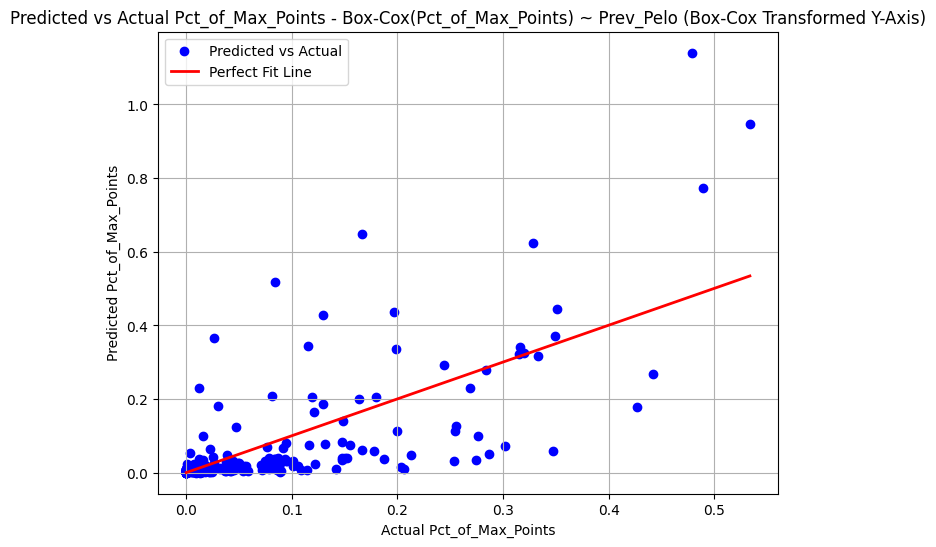

Model Summary for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance
Intercept: -7.757993888682565
Coefficient for Prev_Distance: 0.003850142398113308

Custom R^2 (Train) for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance: 0.3605570709924837
Custom R^2 (Test) for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance: 0.2611022232666964



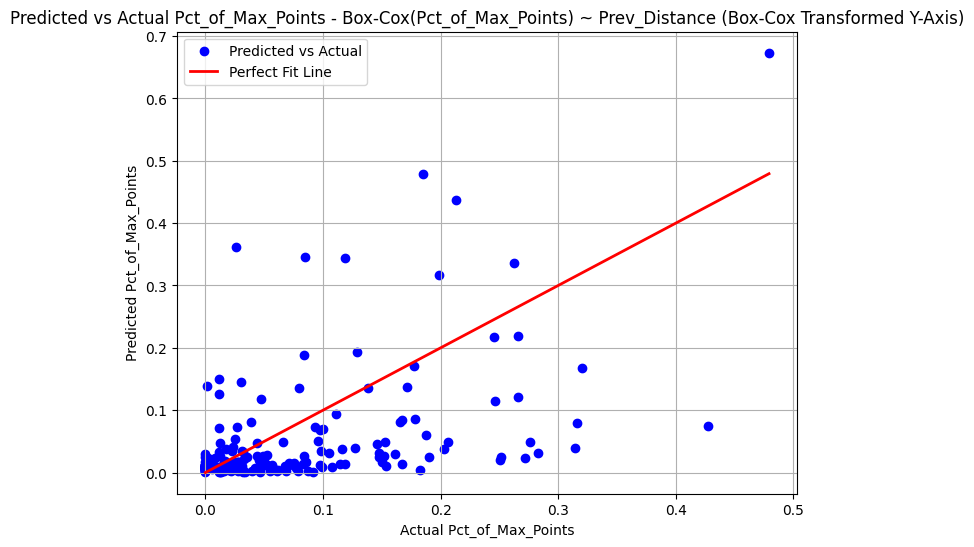

Model Summary for Box-Cox(Pct_of_Max_Points) ~ Prev_Sprint
Intercept: -9.16972601086983
Coefficient for Prev_Sprint: 0.004771290305573092

Custom R^2 (Train) for Box-Cox(Pct_of_Max_Points) ~ Prev_Sprint: 0.33487965515673057
Custom R^2 (Test) for Box-Cox(Pct_of_Max_Points) ~ Prev_Sprint: 0.3079898291025257



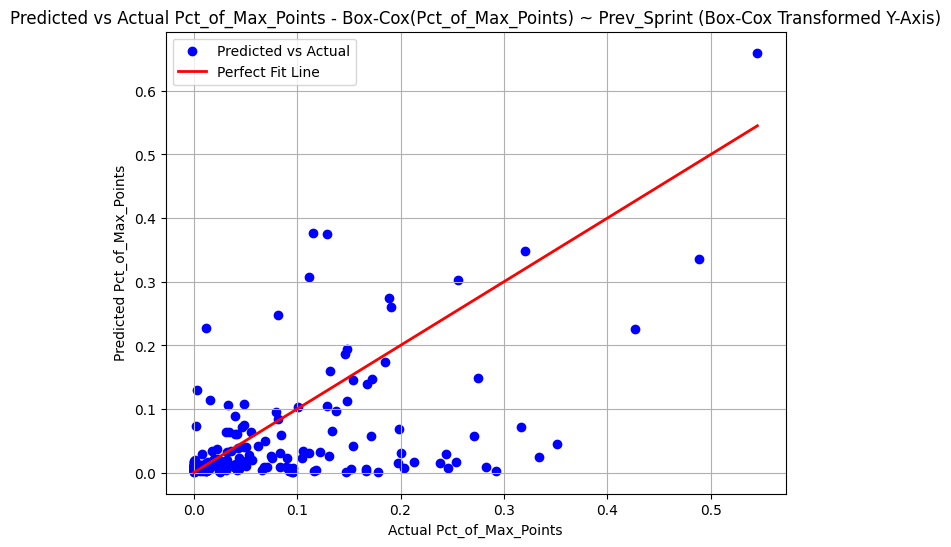

Model Summary for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint
Intercept: -10.068616685148847
Coefficient for Prev_Distance: 0.0027875848539535087
Coefficient for Prev_Sprint: 0.002847825453679737

Custom R^2 (Train) for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint: 0.5133674127971267
Custom R^2 (Test) for Box-Cox(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint: 0.45320254731515497



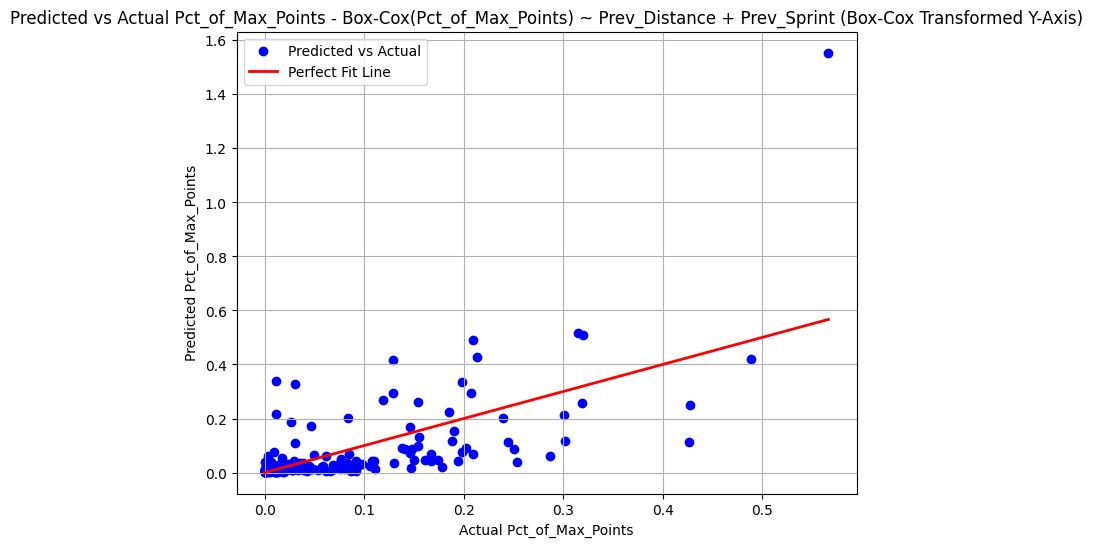

In [138]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for Box-Cox regression
def create_and_plot_boxcox_model(X, y, X_labels, y_label, title, epsilon=1e-5):
    # Add epsilon to y to avoid issues with zero values (Box-Cox requires positive y values)
    y_positive = y + epsilon

    # Apply Box-Cox transformation and find the optimal lambda
    y_boxcox, lambda_boxcox = boxcox(y_positive)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Model Summary for {title}")
    print(f"Intercept: {model.intercept_}")
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for {X_labels[i]}: {coef}")
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using Box-Cox transformed Pct_of_Max_Points
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using Box-Cox transformed Pct_of_Max_Points
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values (inverse Box-Cox transformation applied)
    plt.figure(figsize=(8, 6))
    plt.scatter(inv_boxcox(y_test, lambda_boxcox) - epsilon, inv_boxcox(y_pred_test, lambda_boxcox) - epsilon, color='blue', label='Predicted vs Actual')
    plt.plot([inv_boxcox(y_test.min(), lambda_boxcox) - epsilon, inv_boxcox(y_test.max(), lambda_boxcox) - epsilon],
             [inv_boxcox(y_test.min(), lambda_boxcox) - epsilon, inv_boxcox(y_test.max(), lambda_boxcox) - epsilon],
             color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (Box-Cox Transformed Y-Axis)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with Box-Cox transformed multiple features (Prev_Distance and Prev_Sprint)
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for multiple regression with Box-Cox transformed y-axis
create_and_plot_boxcox_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "Box-Cox(Pct_of_Max_Points) ~ Prev_Pelo")
create_and_plot_boxcox_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "Box-Cox(Pct_of_Max_Points) ~ Prev_Distance")
create_and_plot_boxcox_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "Box-Cox(Pct_of_Max_Points) ~ Prev_Sprint")
create_and_plot_boxcox_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Box-Cox(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint")


(879, 2) (879,)
Quantile Regression Model Summary for Quantile(Pct_of_Max_Points) ~ Prev_Pelo (Quantile: 0.95)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4984
Model:                       QuantReg   Bandwidth:                     0.02597
Method:                 Least Squares   Sparsity:                       0.5838
Date:                Sat, 12 Oct 2024   No. Observations:                  929
Time:                        18:13:35   Df Residuals:                      927
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7320      0.060    -12.286      0.000      -0.849      -0.615
x1             0.0007   4.39e-05     15.181      0.000       0.001       0.001

The condition numbe

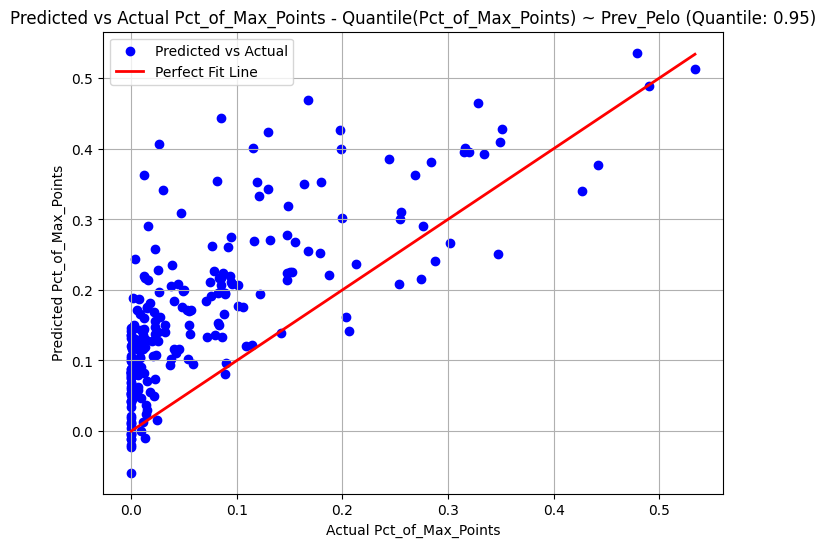

Quantile Regression Model Summary for Quantile(Pct_of_Max_Points) ~ Prev_Distance (Quantile: 0.95)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3405
Model:                       QuantReg   Bandwidth:                     0.03549
Method:                 Least Squares   Sparsity:                        1.375
Date:                Sat, 12 Oct 2024   No. Observations:                  770
Time:                        18:13:35   Df Residuals:                      768
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7062      0.117     -6.019      0.000      -0.936      -0.476
x1             0.0007   8.74e-05      7.939      0.000       0.001       0.001

The condition number is large, 

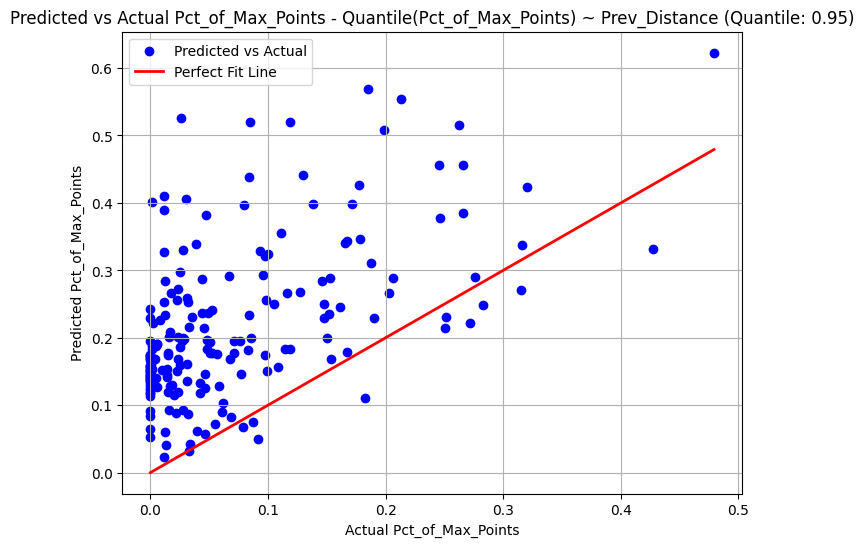

Quantile Regression Model Summary for Quantile(Pct_of_Max_Points) ~ Prev_Sprint (Quantile: 0.95)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.2641
Model:                       QuantReg   Bandwidth:                     0.02730
Method:                 Least Squares   Sparsity:                        1.149
Date:                Sat, 12 Oct 2024   No. Observations:                  862
Time:                        18:13:35   Df Residuals:                      860
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6383      0.119     -5.381      0.000      -0.871      -0.405
x1             0.0006   8.87e-05      7.311      0.000       0.000       0.001

The condition number is large, 1.

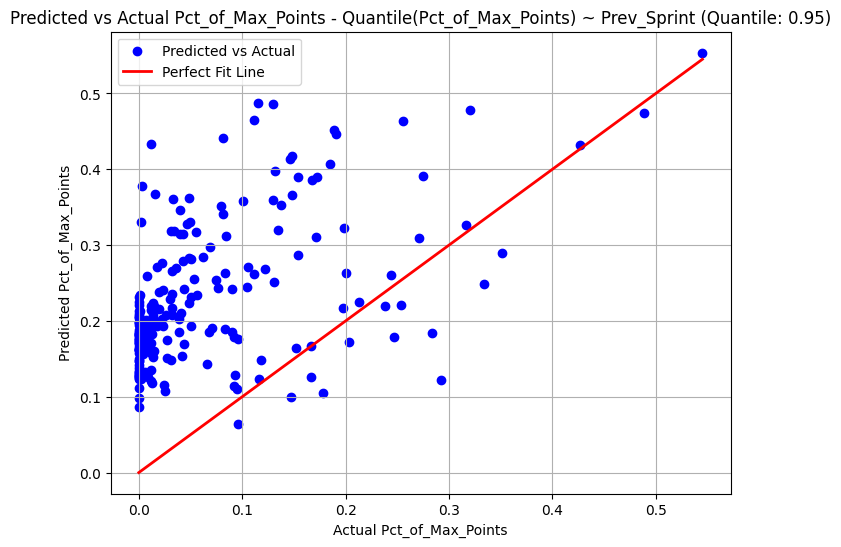

Quantile Regression Model Summary for Quantile(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint (Quantile: 0.95)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.5713
Model:                       QuantReg   Bandwidth:                     0.03202
Method:                 Least Squares   Sparsity:                       0.5396
Date:                Sat, 12 Oct 2024   No. Observations:                  703
Time:                        18:13:35   Df Residuals:                      700
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0985      0.067    -16.361      0.000      -1.230      -0.967
x1             0.0005    3.3e-05     15.302      0.000       0.000       0.001
x2             0.0

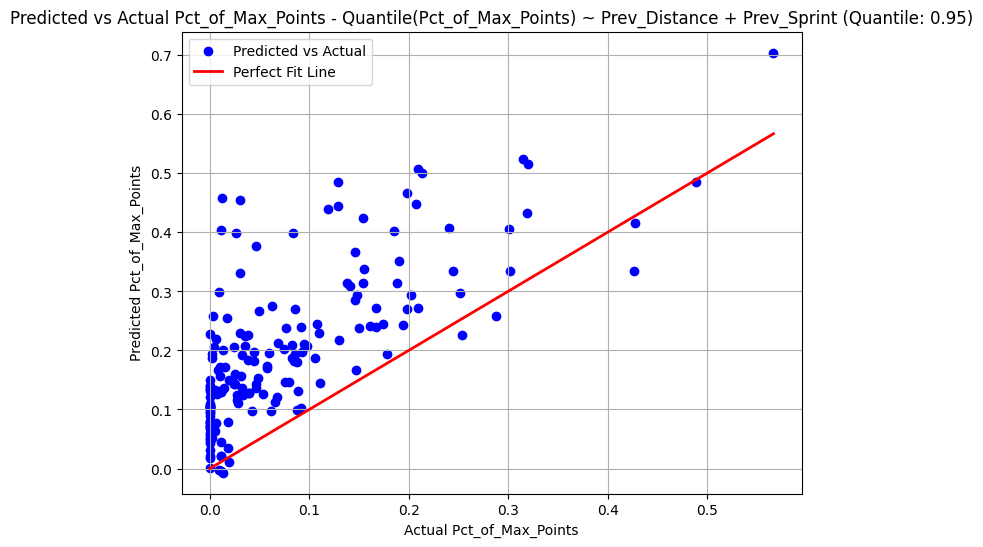

In [142]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for Quantile Regression
def create_and_plot_quantile_model(X, y, X_labels, y_label, title, quantile=0.5, epsilon=1e-5):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add a constant term to X for the intercept in statsmodels (quantile regression requires this)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train the Quantile Regression model
    model = sm.QuantReg(y_train, X_train)
    result = model.fit(q=quantile)

    # Make predictions
    y_pred_train = result.predict(X_train)
    y_pred_test = result.predict(X_test)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Quantile Regression Model Summary for {title} (Quantile: {quantile})")
    print(result.summary())
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using the actual y values for weights
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using the actual y values for weights
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (Quantile: {quantile})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with Quantile Regression
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for Quantile Regression (median, i.e., quantile 0.5)
create_and_plot_quantile_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Pelo", quantile=0.95)
create_and_plot_quantile_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Distance", quantile=0.95)
create_and_plot_quantile_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Sprint", quantile=0.95)
create_and_plot_quantile_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", quantile=0.95)

# You can also experiment with different quantiles like:
# create_and_plot_quantile_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", quantile=0.75)
# create_and_plot_quantile_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Quantile(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", quantile=0.25)


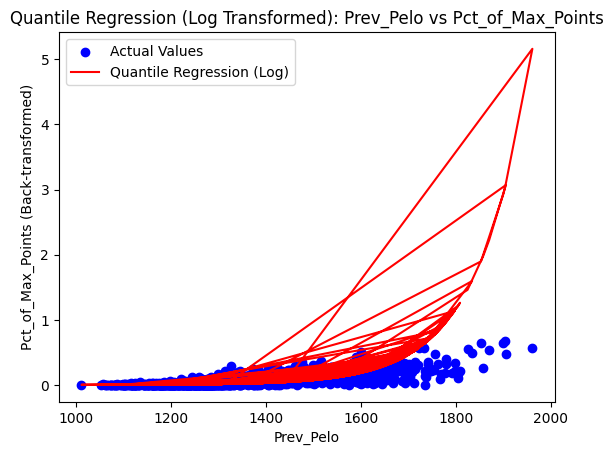

In [13]:
import polars as pl
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Convert your Polars dataframe to Pandas
df_pandas = df.to_pandas()

# 1. Apply log transformation to the target (Pct_of_Max_Points)
# Add a small constant to avoid log(0)
df_pandas['log_Pct_of_Max_Points'] = np.log(df_pandas['Pct_of_Max_Points'] + 1e-6)

# 2. Prepare the data for quantile regression
X = df_pandas[['Prev_Pelo']]  # Independent variable
y_log = df_pandas['log_Pct_of_Max_Points']  # Log-transformed dependent variable

# Add constant to the independent variable (for intercept)
X = sm.add_constant(X)

# 3. Fit the quantile regression model (for median, 50th percentile)
quantile_model = sm.QuantReg(y_log, X)
quantile_fit = quantile_model.fit(q=0.5)  # Fit for the 50th percentile (median)

# 4. Predict values on the log scale
y_log_pred_quantile = quantile_fit.predict(X)

# 5. Back-transform predictions to the original scale (exp)
y_pred_quantile = np.exp(y_log_pred_quantile) - 1e-6

# 6. Visualize the results
plt.scatter(df_pandas['Prev_Pelo'], df_pandas['Pct_of_Max_Points'], color='blue', label='Actual Values')
plt.plot(df_pandas['Prev_Pelo'], y_pred_quantile, color='red', label='Quantile Regression (Log)')

plt.title("Quantile Regression (Log Transformed): Prev_Pelo vs Pct_of_Max_Points")
plt.xlabel("Prev_Pelo")
plt.ylabel("Pct_of_Max_Points (Back-transformed)")
plt.legend()
plt.show()


(879, 2) (879,)
Polynomial Regression Model Summary for Polynomial(Pct_of_Max_Points) ~ Prev_Pelo (Degree: 5)
Intercept: 3.9603042903915773
Coefficient for 1: 0.0
Coefficient for Prev_Pelo: -2.750630557432562e-08
Coefficient for Prev_Pelo^2: -1.9550833143247443e-05
Coefficient for Prev_Pelo^3: 2.6905328274647403e-08
Coefficient for Prev_Pelo^4: -1.3739638878784132e-11
Coefficient for Prev_Pelo^5: 2.48919782436218e-15

Custom R^2 (Train) for Polynomial(Pct_of_Max_Points) ~ Prev_Pelo: 0.7270041818701521
Custom R^2 (Test) for Polynomial(Pct_of_Max_Points) ~ Prev_Pelo: 0.7278748680101604



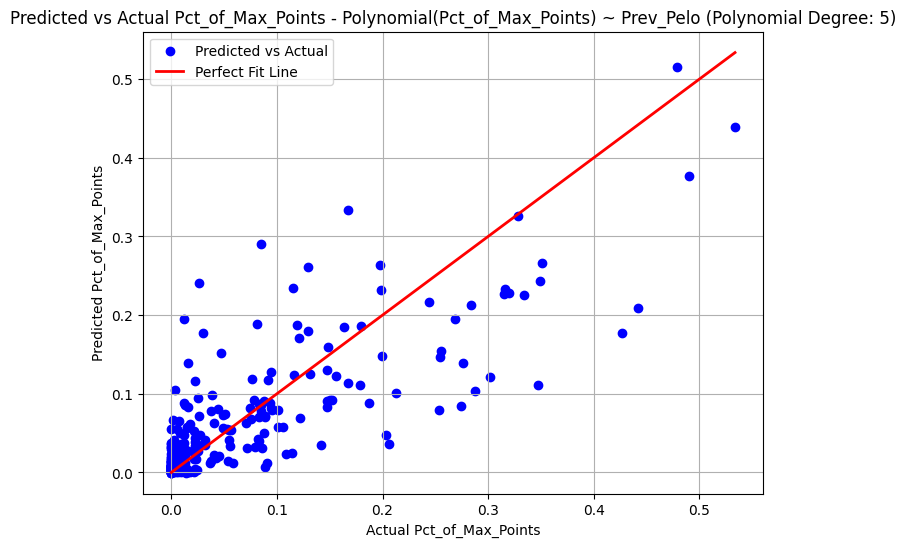

Polynomial Regression Model Summary for Polynomial(Pct_of_Max_Points) ~ Prev_Distance (Degree: 5)
Intercept: 3.0478059832603988
Coefficient for 1: 0.0
Coefficient for Prev_Distance: -2.1037492431770197e-08
Coefficient for Prev_Distance^2: -1.5088108067077885e-05
Coefficient for Prev_Distance^3: 2.0930816128659614e-08
Coefficient for Prev_Distance^4: -1.08096806604707e-11
Coefficient for Prev_Distance^5: 1.9897206602525706e-15

Custom R^2 (Train) for Polynomial(Pct_of_Max_Points) ~ Prev_Distance: 0.6280139599679766
Custom R^2 (Test) for Polynomial(Pct_of_Max_Points) ~ Prev_Distance: 0.41008895791734346



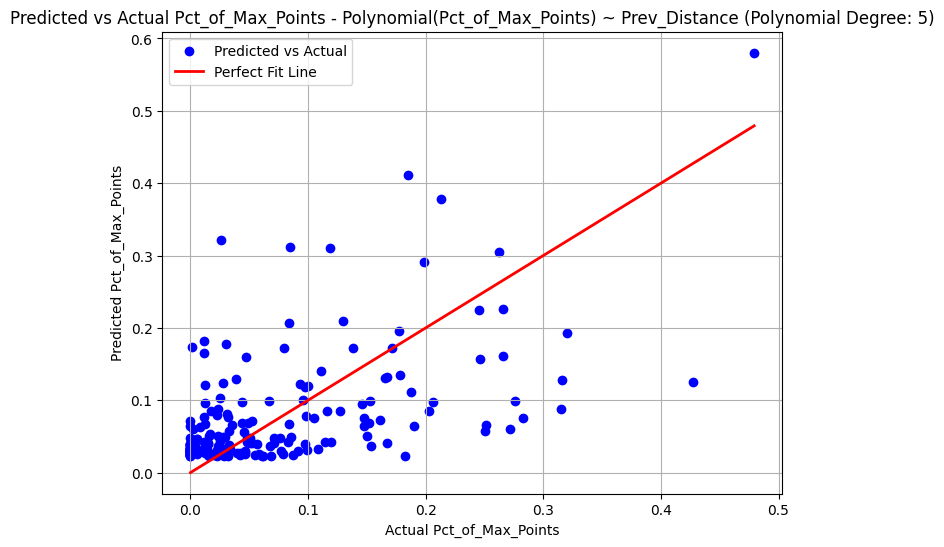

Polynomial Regression Model Summary for Polynomial(Pct_of_Max_Points) ~ Prev_Sprint (Degree: 5)
Intercept: 7.711912024007118
Coefficient for 1: 0.0
Coefficient for Prev_Sprint: -5.341441746803468e-08
Coefficient for Prev_Sprint^2: -3.809576557407922e-05
Coefficient for Prev_Sprint^3: 5.2915887965890975e-08
Coefficient for Prev_Sprint^4: -2.7376373352554807e-11
Coefficient for Prev_Sprint^5: 5.022186074192215e-15

Custom R^2 (Train) for Polynomial(Pct_of_Max_Points) ~ Prev_Sprint: 0.5126932900198944
Custom R^2 (Test) for Polynomial(Pct_of_Max_Points) ~ Prev_Sprint: 0.5108479141113527



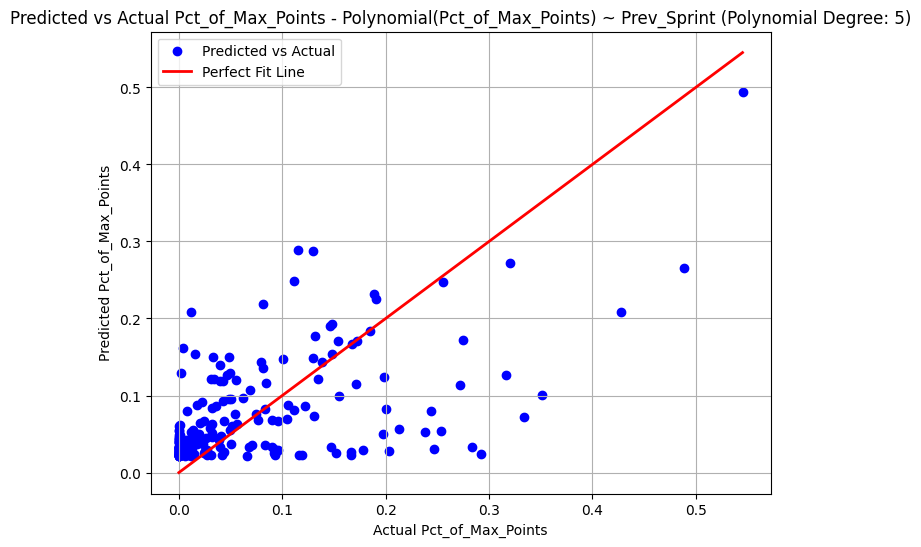

Polynomial Regression Model Summary for Polynomial(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint (Degree: 5)
Intercept: 9.838349593797359
Coefficient for 1: 0.0
Coefficient for Prev_Distance: -1.666695933310854e-07
Coefficient for Prev_Sprint: -4.173480003756981e-08
Coefficient for Prev_Distance^2: 6.255460047975205e-05
Coefficient for Prev_Distance Prev_Sprint: -0.00016616064672485937
Coefficient for Prev_Sprint^2: 5.309200628966838e-05
Coefficient for Prev_Distance^3: -1.3312214020733368e-07
Coefficient for Prev_Distance^2 Prev_Sprint: 2.8700069729116514e-07
Coefficient for Prev_Distance Prev_Sprint^2: -8.628324836442127e-08
Coefficient for Prev_Sprint^3: 3.845784975807929e-09
Coefficient for Prev_Distance^4: 7.01684213789541e-11
Coefficient for Prev_Distance^3 Prev_Sprint: -9.577101908266498e-11
Coefficient for Prev_Distance^2 Prev_Sprint^2: -6.969535116125679e-11
Coefficient for Prev_Distance Prev_Sprint^3: 8.311155822989199e-11
Coefficient for Prev_Sprint^4: -2.5434209353350597

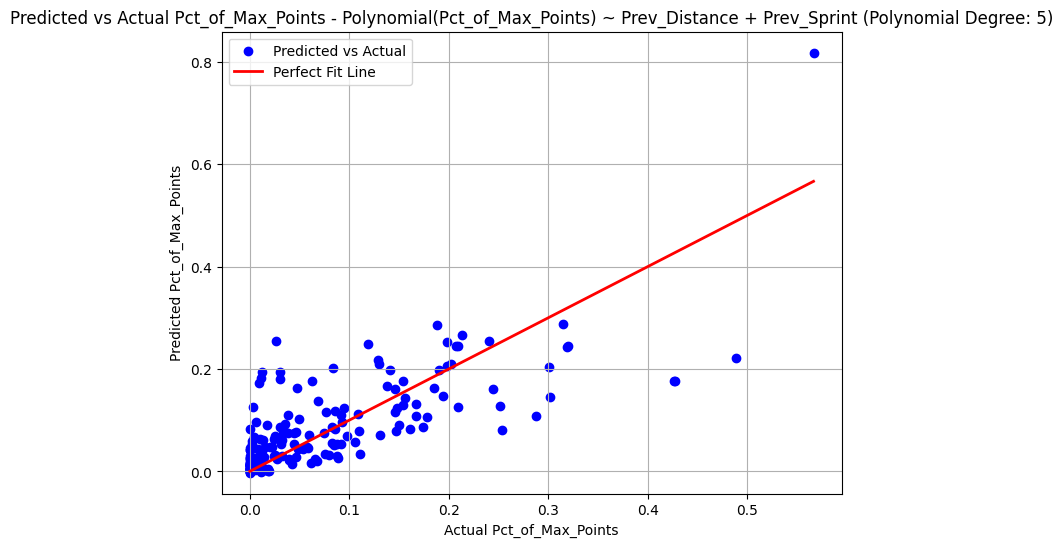

In [146]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for Polynomial Regression
def create_and_plot_polynomial_model(X, y, X_labels, y_label, title, degree=2, epsilon=1e-5):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Train the Linear Regression model on polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)

    # Print model coefficients and intercept (Summary Statistics)
    print(f"Polynomial Regression Model Summary for {title} (Degree: {degree})")
    print(f"Intercept: {model.intercept_}")
    coef_labels = poly.get_feature_names_out(X_labels)
    for i, coef in enumerate(model.coef_):
        print(f"Coefficient for {coef_labels[i]}: {coef}")
    print()

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using the actual y values for weights
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using the actual y values for weights
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (Polynomial Degree: {degree})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with Polynomial Regression
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for Polynomial Regression (degree 2)
create_and_plot_polynomial_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "Polynomial(Pct_of_Max_Points) ~ Prev_Pelo", degree=5)
create_and_plot_polynomial_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "Polynomial(Pct_of_Max_Points) ~ Prev_Distance", degree=5)
create_and_plot_polynomial_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "Polynomial(Pct_of_Max_Points) ~ Prev_Sprint", degree=5)
create_and_plot_polynomial_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Polynomial(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", degree=5)

# You can also experiment with different polynomial degrees like:
# create_and_plot_polynomial_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "Polynomial(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", degree=3)


(879, 2) (879,)
KNN Regression Model Summary for KNN(Pct_of_Max_Points) ~ Prev_Pelo (n_neighbors: 1)
Custom R^2 (Train) for KNN(Pct_of_Max_Points) ~ Prev_Pelo: 1.0
Custom R^2 (Test) for KNN(Pct_of_Max_Points) ~ Prev_Pelo: 0.4243287437842286

shape: (929, 3)
┌─────────────┬───────────────────┬───────────┐
│ Prev_Pelo   ┆ Pct_of_Max_Points ┆ Predicted │
│ ---         ┆ ---               ┆ ---       │
│ f64         ┆ f64               ┆ f64       │
╞═════════════╪═══════════════════╪═══════════╡
│ 1181.291052 ┆ 0.0               ┆ 0.0       │
│ 1158.537158 ┆ 0.0               ┆ 0.0       │
│ 1182.95913  ┆ 0.0               ┆ 0.0       │
│ 1246.412399 ┆ 0.0               ┆ 0.0       │
│ 1224.540701 ┆ 0.0               ┆ 0.0       │
│ …           ┆ …                 ┆ …         │
│ 1960.900235 ┆ 0.566588          ┆ 0.566588  │
│ 1721.253094 ┆ 0.572471          ┆ 0.572471  │
│ 1852.649141 ┆ 0.635949          ┆ 0.635949  │
│ 1899.379914 ┆ 0.636552          ┆ 0.636552  │
│ 1903.219718 ┆ 0.6762

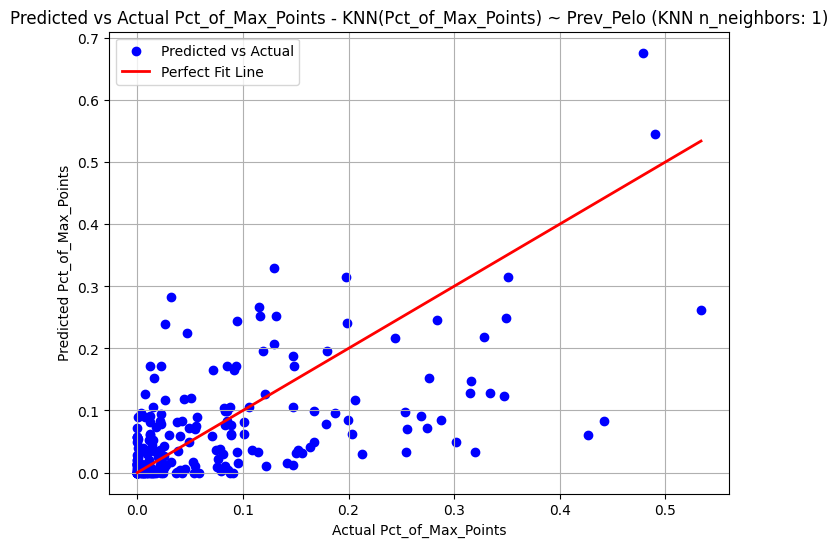

KNN Regression Model Summary for KNN(Pct_of_Max_Points) ~ Prev_Distance (n_neighbors: 1)
Custom R^2 (Train) for KNN(Pct_of_Max_Points) ~ Prev_Distance: 0.9969135267058232
Custom R^2 (Test) for KNN(Pct_of_Max_Points) ~ Prev_Distance: 0.07572274483962249

shape: (770, 3)
┌───────────────┬───────────────────┬───────────┐
│ Prev_Distance ┆ Pct_of_Max_Points ┆ Predicted │
│ ---           ┆ ---               ┆ ---       │
│ f64           ┆ f64               ┆ f64       │
╞═══════════════╪═══════════════════╪═══════════╡
│ 1379.300211   ┆ 0.0               ┆ 0.0       │
│ 1243.77074    ┆ 0.0               ┆ 0.0       │
│ 1262.582935   ┆ 0.0               ┆ 0.0       │
│ 1273.086478   ┆ 0.0               ┆ 0.0       │
│ 1162.964065   ┆ 0.0               ┆ 0.0       │
│ …             ┆ …                 ┆ …         │
│ 1879.946812   ┆ 0.566588          ┆ 0.566588  │
│ 1721.529002   ┆ 0.572471          ┆ 0.572471  │
│ 1817.181699   ┆ 0.635949          ┆ 0.635949  │
│ 1885.485      ┆ 0.636552    

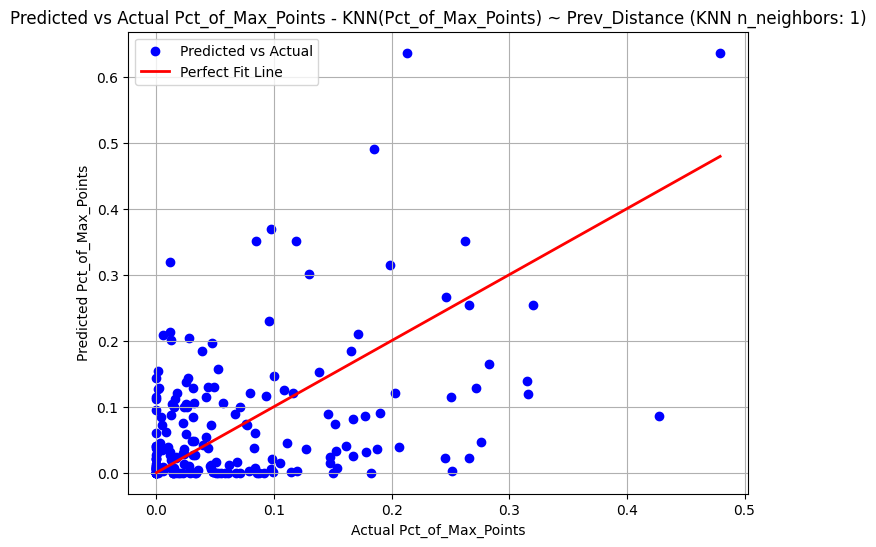

KNN Regression Model Summary for KNN(Pct_of_Max_Points) ~ Prev_Sprint (n_neighbors: 1)
Custom R^2 (Train) for KNN(Pct_of_Max_Points) ~ Prev_Sprint: 0.9896488428587586
Custom R^2 (Test) for KNN(Pct_of_Max_Points) ~ Prev_Sprint: 0.47865558462902724

shape: (862, 3)
┌─────────────┬───────────────────┬───────────┐
│ Prev_Sprint ┆ Pct_of_Max_Points ┆ Predicted │
│ ---         ┆ ---               ┆ ---       │
│ f64         ┆ f64               ┆ f64       │
╞═════════════╪═══════════════════╪═══════════╡
│ 1161.005174 ┆ 0.0               ┆ 0.0       │
│ 1233.39821  ┆ 0.0               ┆ 0.0       │
│ 1201.013469 ┆ 0.0               ┆ 0.0       │
│ 1240.982527 ┆ 0.0               ┆ 0.0       │
│ 1157.597796 ┆ 0.0               ┆ 0.0       │
│ …           ┆ …                 ┆ …         │
│ 1857.858421 ┆ 0.566588          ┆ 0.566588  │
│ 1500.287015 ┆ 0.572471          ┆ 0.572471  │
│ 1704.368302 ┆ 0.635949          ┆ 0.635949  │
│ 1729.10085  ┆ 0.636552          ┆ 0.636552  │
│ 1838.024991 ┆ 

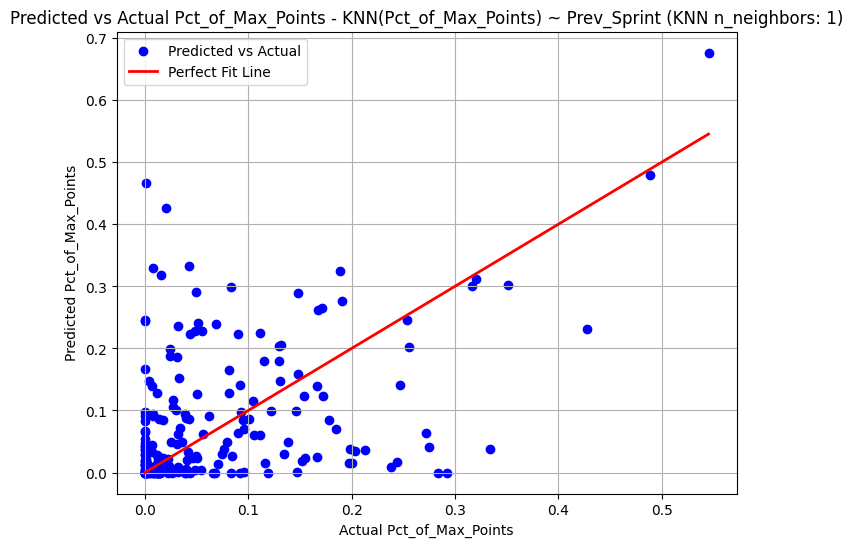

KNN Regression Model Summary for KNN(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint (n_neighbors: 1)
Custom R^2 (Train) for KNN(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint: 1.0
Custom R^2 (Test) for KNN(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint: 0.5779215950929386

shape: (703, 3)
┌───────────────┬───────────────────┬───────────┐
│ Prev_Distance ┆ Pct_of_Max_Points ┆ Predicted │
│ ---           ┆ ---               ┆ ---       │
│ f64           ┆ f64               ┆ f64       │
╞═══════════════╪═══════════════════╪═══════════╡
│ 1088.895468   ┆ 0.0               ┆ 0.0       │
│ 1216.212852   ┆ 0.0               ┆ 0.0       │
│ 1093.708733   ┆ 0.0               ┆ 0.0       │
│ 1231.684144   ┆ 0.0               ┆ 0.0       │
│ 1224.732599   ┆ 0.0               ┆ 0.0       │
│ …             ┆ …                 ┆ …         │
│ 1735.79275    ┆ 0.560267          ┆ 0.560267  │
│ 1721.529002   ┆ 0.572471          ┆ 0.572471  │
│ 1817.181699   ┆ 0.635949          ┆ 0.635949  │
│ 18

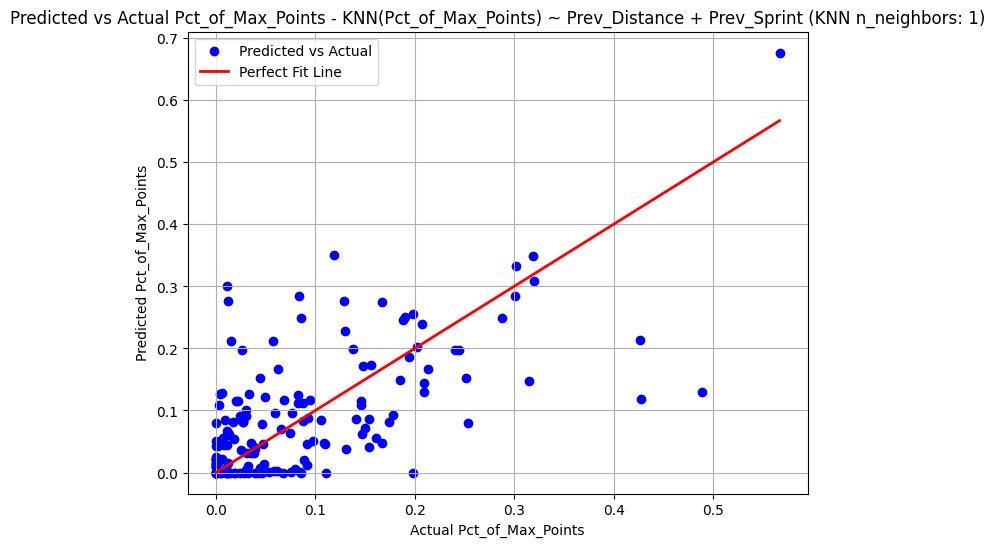

In [159]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Function to calculate summary statistics, custom residuals, and plot predicted vs actual for KNN Regression
def create_and_plot_knn_model(X, y, X_labels, y_label, title, n_neighbors=1, epsilon=1e-5):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the KNN Regressor
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    # Print model summary
    print(f"KNN Regression Model Summary for {title} (n_neighbors: {n_neighbors})")

    # Calculate the mean of y_train for the weighted R^2 calculation
    y_train_mean = np.mean(y_train)

    # Calculate weighted residual sum of squares (RSS) for training data
    custom_weight_train = y_train  # Using the actual y values for weights
    weighted_rss_train = np.sum(custom_weight_train * (y_train - y_pred_train) ** 2)

    # Calculate weighted total sum of squares (TSS) for training data
    weighted_tss_train = np.sum(custom_weight_train * (y_train - y_train_mean) ** 2)

    # Custom R^2-like score for training data
    custom_r2_train = 1 - (weighted_rss_train / weighted_tss_train)

    # Calculate the mean of y_test for the weighted R^2 calculation
    y_test_mean = np.mean(y_test)

    # Calculate weighted residual sum of squares (RSS) for test data
    custom_weight_test = y_test  # Using the actual y values for weights
    weighted_rss_test = np.sum(custom_weight_test * (y_test - y_pred_test) ** 2)

    # Calculate weighted total sum of squares (TSS) for test data
    weighted_tss_test = np.sum(custom_weight_test * (y_test - y_test_mean) ** 2)

    # Custom R^2-like score for test data
    custom_r2_test = 1 - (weighted_rss_test / weighted_tss_test)

    # Print the custom R^2 scores
    print(f"Custom R^2 (Train) for {title}: {custom_r2_train}")
    print(f"Custom R^2 (Test) for {title}: {custom_r2_test}\n")

    test_df = pl.DataFrame({
        X_labels[0]: X_train[:, 0],  # Assuming X has a single feature
        y_label: y_train,
        'Predicted': y_pred_train
    })

    # Print the DataFrame for further inspection
    print(test_df.sort("Pct_of_Max_Points"))

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit Line')
    plt.xlabel(f"Actual {y_label}")
    plt.ylabel(f"Predicted {y_label}")
    plt.title(f"Predicted vs Actual {y_label} - {title} (KNN n_neighbors: {n_neighbors})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with KNN Regression
df_filtered = both_df.filter(
    pl.col("Prev_Distance").is_not_null() & 
    pl.col("Prev_Sprint").is_not_null() & 
    pl.col("Pct_of_Max_Points").is_not_null()
)

# Select the data for both X (Prev_Distance and Prev_Sprint) and y (Pct_of_Max_Points)
X_both = df_filtered.select(["Prev_Distance", "Prev_Sprint"]).to_numpy()
y_both = df_filtered.select("Pct_of_Max_Points").to_numpy().ravel()

# Ensure X_both and y_both have the same length
print(X_both.shape, y_both.shape)

# Call the function for KNN Regression with 5 neighbors
create_and_plot_knn_model(X_elo, y_elo, ["Prev_Pelo"], "Pct_of_Max_Points", "KNN(Pct_of_Max_Points) ~ Prev_Pelo", n_neighbors=1)
create_and_plot_knn_model(X_distance, y_distance, ["Prev_Distance"], "Pct_of_Max_Points", "KNN(Pct_of_Max_Points) ~ Prev_Distance", n_neighbors=1)
create_and_plot_knn_model(X_sprint, y_sprint, ["Prev_Sprint"], "Pct_of_Max_Points", "KNN(Pct_of_Max_Points) ~ Prev_Sprint", n_neighbors=1)
create_and_plot_knn_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "KNN(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", n_neighbors=1)

# You can also experiment with different number of neighbors like:
# create_and_plot_knn_model(X_both, y_both, ["Prev_Distance", "Prev_Sprint"], "Pct_of_Max_Points", "KNN(Pct_of_Max_Points) ~ Prev_Distance + Prev_Sprint", n_neighbors=10)


Mean Squared Error: 0.004108095885397237


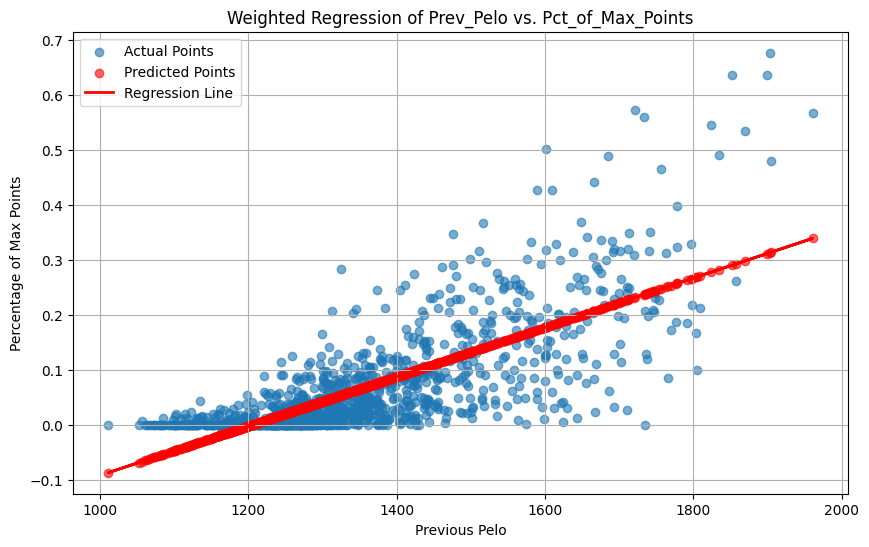

In [15]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample data setup (Replace this with your actual DataFrame)
# Assuming df is your DataFrame containing the relevant columns
# Example:
# df = pl.DataFrame({
#     'ID': [...],
#     'Prev_Pelo': [...],
#     'Pct_of_Max_Points': [...],
#     'Place': [...],
# })

# 1. Filter for top skiers (e.g., top 10% based on their points)
top_skiers = df.filter(pl.col('Place') <= 10)  # You can adjust this filter to define "top skiers"

# 2. Assign weights based on some criteria (e.g., higher weight for better placements)
top_skiers = top_skiers.with_columns(
    pl.when(pl.col('Place') <= 10).then(60).otherwise(1).alias('Weight')  # Weight top placements higher
)

# 3. Prepare your feature matrix and target variable
X = top_skiers.select(['Prev_Pelo']).to_numpy()
y = top_skiers.select(['Pct_of_Max_Points']).to_numpy()
weights = top_skiers.select(['Weight']).to_numpy().ravel()

# 4. Fit the weighted regression model
model = LinearRegression()
model.fit(X, y, sample_weight=weights)

# 5. Predictions
predictions = model.predict(X)

# 6. Calculate Mean Squared Error for evaluation
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')

# 7. Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Points', alpha=0.6)
plt.scatter(X, predictions, color='red', label='Predicted Points', alpha=0.6)
plt.plot(X, predictions, color='red', linewidth=2, label='Regression Line')
plt.title('Weighted Regression of Prev_Pelo vs. Pct_of_Max_Points')
plt.xlabel('Previous Pelo')
plt.ylabel('Percentage of Max Points')
plt.legend()
plt.grid()
plt.show()



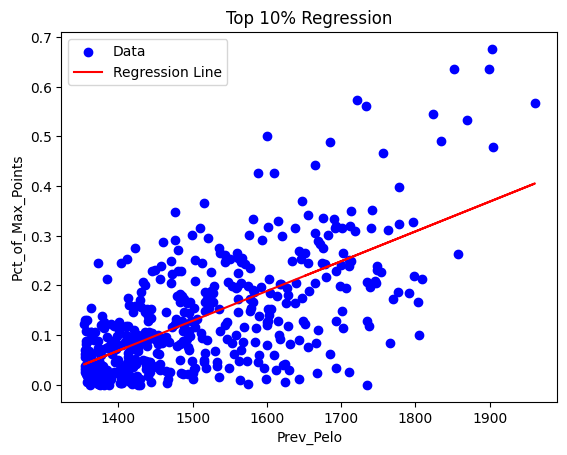

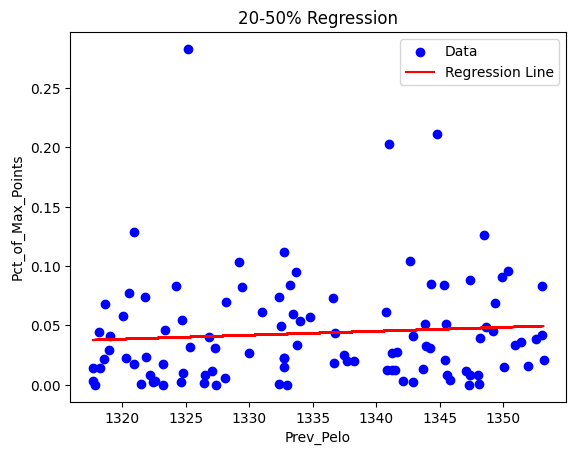

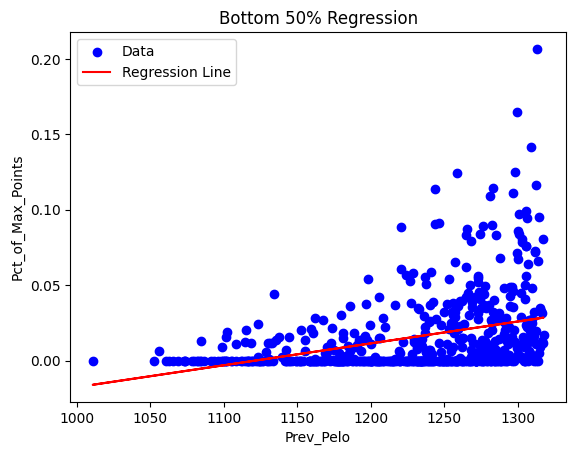

In [87]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample data setup (Replace this with your actual DataFrame)
# df = ...

# 1. Define the segmentation thresholds
top_10_threshold = df.select(pl.col("Prev_Pelo").quantile(0.59)).item()
bottom_50_threshold = df.select(pl.col("Prev_Pelo").quantile(0.50)).item()
# 2. Segment the data
df = df.with_columns([
    pl.when(pl.col("Prev_Pelo") >= top_10_threshold).then(pl.lit("Top 10%"))
    .when((pl.col("Prev_Pelo") < top_10_threshold) & (pl.col("Prev_Pelo") >= bottom_50_threshold)).then(pl.lit("20-50%"))
    .otherwise(pl.lit("Bottom 50%")).alias("Segment")
])


# Filter data by segments
top_10_df = df.filter(pl.col("Segment") == "Top 10%")
middle_20_50_df = df.filter(pl.col("Segment") == "20-50%")
bottom_50_df = df.filter(pl.col("Segment") == "Bottom 50%")


from sklearn.linear_model import LinearRegression
import numpy as np

# Function to fit regression model
def run_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# For top 10% segment
X_top = top_10_df.select(pl.col("Prev_Pelo")).to_numpy().reshape(-1, 1)
y_top = top_10_df.select(pl.col("Pct_of_Max_Points")).to_numpy()

top_model = run_regression(X_top, y_top)

# For 20-50% segment
X_middle = middle_20_50_df.select(pl.col("Prev_Pelo")).to_numpy().reshape(-1, 1)
y_middle = middle_20_50_df.select(pl.col("Pct_of_Max_Points")).to_numpy()

middle_model = run_regression(X_middle, y_middle)

# For bottom 50% segment
X_bottom = bottom_50_df.select(pl.col("Prev_Pelo")).to_numpy().reshape(-1, 1)
y_bottom = bottom_50_df.select(pl.col("Pct_of_Max_Points")).to_numpy()

bottom_model = run_regression(X_bottom, y_bottom)



import matplotlib.pyplot as plt

# Function to plot regression
def plot_regression(X, y, model, title):
    plt.scatter(X, y, color='blue', label='Data')
    plt.plot(X, model.predict(X), color='red', label='Regression Line')
    plt.title(title)
    plt.xlabel('Prev_Pelo')
    plt.ylabel('Pct_of_Max_Points')
    plt.legend()
    plt.show()

# Plot for top 10%
plot_regression(X_top, y_top, top_model, "Top 10% Regression")

# Plot for 20-50%
plot_regression(X_middle, y_middle, middle_model, "20-50% Regression")

# Plot for bottom 50%
plot_regression(X_bottom, y_bottom, bottom_model, "Bottom 50% Regression")



                            OLS Regression Results                            
Dep. Variable:      Pct_of_Max_Points   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     249.1
Date:                Wed, 09 Oct 2024   Prob (F-statistic):          1.25e-225
Time:                        11:33:00   Log-Likelihood:                 1593.9
No. Observations:                1162   AIC:                            -3172.
Df Residuals:                    1154   BIC:                            -3131.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5940      0.05

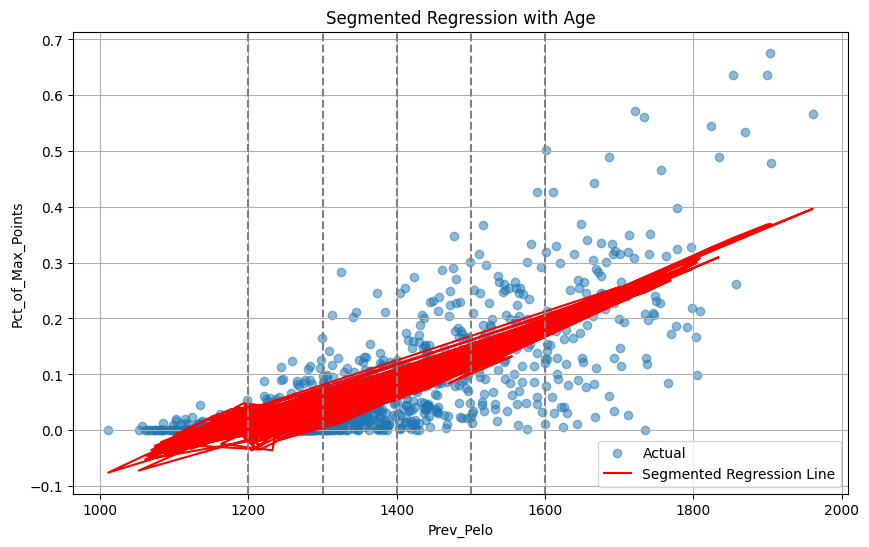

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy

# Assuming df is your Polars DataFrame, convert it to Pandas for modeling
df_pandas = df.to_pandas()

# Clean the 'Age' column: replace "None" with NaN and then convert to numeric
df_pandas['Age'] = pd.to_numeric(df_pandas['Age'].replace("None", np.nan), errors='coerce')

# Optionally, drop rows with NaN values in 'Age' or fill them
# df_pandas.dropna(subset=['Age'], inplace=True)  # Uncomment to drop rows
# df_pandas['Age'].fillna(df_pandas['Age'].median(), inplace=True)  # Uncomment to fill NaN values

# Define breakpoints for segmented regression
breakpoints = [1200, 1300, 1400, 1500, 1600]

# Create the design matrix for segmented regression
# Adding Age as an independent variable
formula = "Pct_of_Max_Points ~ Prev_Pelo + Age + C(segmented)"
df_pandas['segmented'] = pd.cut(df_pandas['Prev_Pelo'], bins=[-np.inf] + breakpoints + [np.inf], labels=range(len(breakpoints) + 1))

# Create y and X matrices
y, X = patsy.dmatrices(formula, df_pandas, return_type='dataframe')

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

# Make predictions for plotting
df_pandas['predicted'] = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['Prev_Pelo'], df_pandas['Pct_of_Max_Points'], label='Actual', alpha=0.5)
plt.plot(df_pandas['Prev_Pelo'], df_pandas['predicted'], color='red', label='Segmented Regression Line')
plt.axvline(x=breakpoints[0], color='gray', linestyle='--')
plt.axvline(x=breakpoints[1], color='gray', linestyle='--')
plt.axvline(x=breakpoints[2], color='gray', linestyle='--')
plt.axvline(x=breakpoints[3], color='gray', linestyle='--')
plt.axvline(x=breakpoints[4], color='gray', linestyle='--')
plt.xlabel('Prev_Pelo')
plt.ylabel('Pct_of_Max_Points')
plt.title('Segmented Regression with Age')
plt.legend()
plt.grid()
plt.show()



Optimization terminated successfully.
         Current function value: 1143.764751
         Iterations: 11
         Function evaluations: 18
         Gradient evaluations: 18
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1143.7647513559157
        x: [ 1.637e-01  6.226e-01  7.357e-01]
      nit: 11
      jac: [ 2.127e-06  2.247e-06 -1.953e-06]
 hess_inv: [[ 5.601e-04 -3.494e-05  6.328e-05]
            [-3.494e-05  5.582e-04 -5.986e-05]
            [ 6.328e-05 -5.986e-05  3.063e-04]]
     nfev: 18
     njev: 18


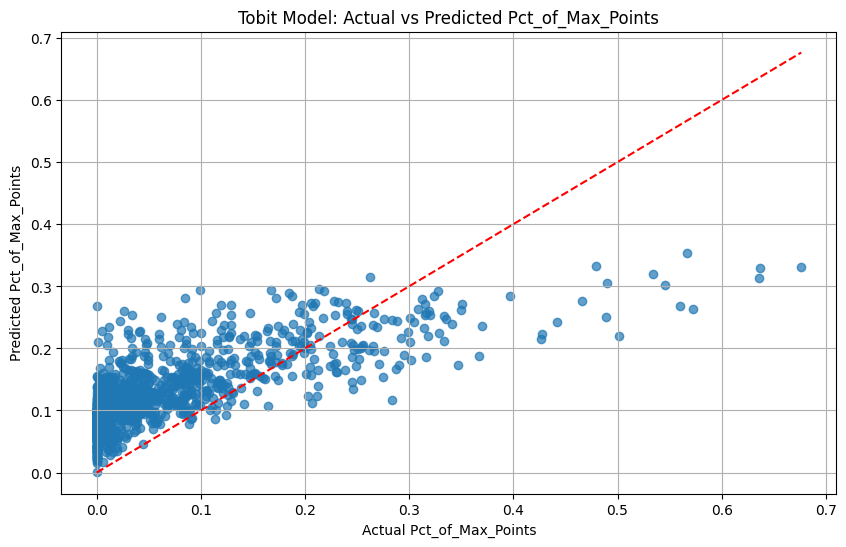

In [57]:
import polars as pl
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df is your Polars DataFrame
cens = (df['Pct_of_Max_Points'] == 0).cast(pl.Int32)

# Extract features and target variable
X = df[['Prev_Pelo']].to_pandas()  # Convert to Pandas DataFrame
y = df['Pct_of_Max_Points'].to_pandas()  # Convert to Pandas Series
cens = cens.to_pandas()  # Convert to Pandas Series

# Convert all column names of X to strings
X.columns = X.columns.astype(str)

# Create an instance of the Tobit model
tobit_model = TobitModel()

# Standardize the features and target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Fit the model with scaled data
tobit_model.fit(pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_scaled), cens, verbose=True)

# Make predictions
y_pred_scaled = tobit_model.predict(X_scaled)

# Inverse scale the predictions and actuals back to their original scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Line of equality
plt.xlabel('Actual Pct_of_Max_Points')
plt.ylabel('Predicted Pct_of_Max_Points')
plt.title('Tobit Model: Actual vs Predicted Pct_of_Max_Points')
plt.grid()
plt.show()


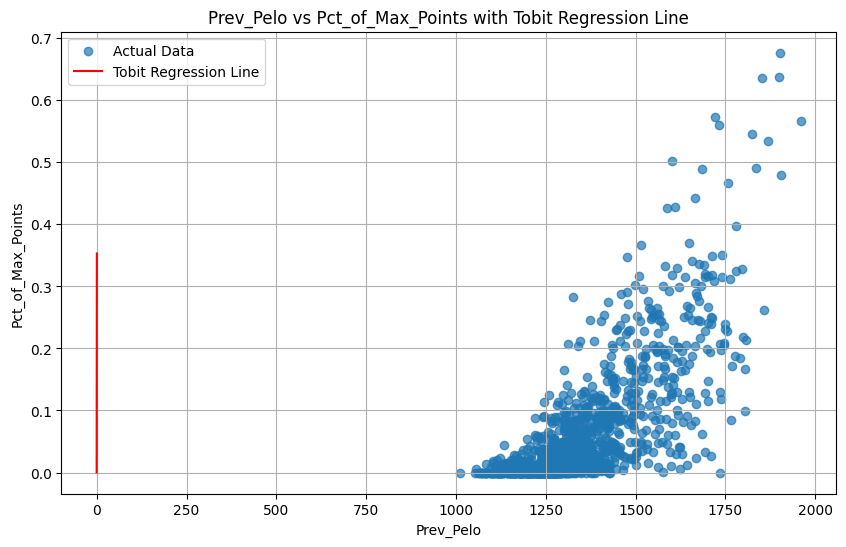

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions for plotting the regression line
X_scaled_for_plot = np.linspace(X_scaled.min(), X_scaled.max(), 100).reshape(-1, 1)  # 100 points evenly spaced
y_pred_scaled_for_plot = tobit_model.predict(X_scaled_for_plot)

# Inverse-transform the predicted values back to original scale
y_pred_for_plot = scaler.inverse_transform(y_pred_scaled_for_plot.reshape(-1, 1)).flatten()

# Inverse-transform X_scaled for plotting as well
X_original_for_plot = scaler.inverse_transform(X_scaled_for_plot).flatten()

# Plot the original data points (Prev_Pelo vs Pct_of_Max_Points)
plt.figure(figsize=(10, 6))
plt.scatter(X['Prev_Pelo'], y, alpha=0.7, label='Actual Data')

# Plot the Tobit regression line (Predicted Pct_of_Max_Points)
plt.plot(X_original_for_plot, y_pred_for_plot, color='red', label='Tobit Regression Line')

# Labels and title
plt.xlabel('Prev_Pelo')
plt.ylabel('Pct_of_Max_Points')
plt.title('Prev_Pelo vs Pct_of_Max_Points with Tobit Regression Line')
plt.legend()
plt.grid()
plt.show()


In [55]:
print(cens.value_counts())

Pct_of_Max_Points
0    901
1    263
Name: count, dtype: int64


In [43]:
df

Date,City,Country,Event,Sex,Distance,MS,Technique,Place,Skier,Nation,ID,Season,Race,Birthday,Age,Exp,Pelo,Elo,Distance_Pelo,Distance_Elo,Distance_C_Pelo,Distance_C_Elo,Distance_F_Pelo,Distance_F_Elo,Sprint_Pelo,Sprint_Elo,Sprint_C_Pelo,Sprint_C_Elo,Sprint_F_Pelo,Sprint_F_Elo,Classic_Pelo,Classic_Elo,Freestyle_Pelo,Freestyle_Elo,Points,Cumulative_Points,Max_Points,Pct_of_Max_Points,Prev_Pelo,Log_Pct_of_Max_Points,Sqrt_Pct_of_Max_Points,BoxCox_Cumulative_Points,Quantile_Cumulative_Points,Prev_Pelo_Squared,Segment
str,str,str,str,str,str,i64,str,i64,str,str,i64,i64,i64,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str
"""2020-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Dario Cologna""","""Switzerland""",4,2020,0,"""1986-03-11 00:00:00.000000""","""33.99315537303217""",341,1664.558841,1609.875015,1739.947011,1673.954959,1609.977451,1563.480834,1662.848242,1662.848242,1373.014397,1373.014397,1357.650944,1357.650944,1378.325097,1378.325097,1549.990126,1512.491607,1588.685698,1588.685698,0,1046,3950,0.26481,1651.943472,-0.577064,0.514597,0.081231,1.640385,1.5134e32,"""20-50%"""
"""2021-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Dario Cologna""","""Switzerland""",4,2021,0,"""1986-03-11 00:00:00.000000""","""35.00889801505818""",366,1685.693045,1627.839088,1694.209636,1635.078191,1597.17085,1597.17085,1615.964692,1568.569988,1422.691219,1422.691219,1345.30425,1345.30425,1460.542449,1460.542449,1557.554493,1557.554493,1607.406681,1561.295678,0,884,2900,0.304828,1664.558841,-0.515944,0.552112,0.082996,1.830707,1.6330e32,"""20-50%"""
"""2022-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Dario Cologna""","""Switzerland""",4,2022,0,"""1986-03-11 00:00:00.000000""","""35.98631074606434""",377,1537.549478,1501.917057,1617.511155,1569.884482,1539.655351,1503.707048,1582.9223,1582.9223,1332.022883,1332.022883,1281.005202,1281.005202,1381.090634,1381.090634,1482.584219,1455.196586,1517.81123,1517.81123,0,161,2600,0.061923,1685.693045,-1.20814,0.248843,0.043404,0.422972,1.8526e32,"""Top 10%"""
"""2020-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Daniel Rickardsson""","""Sweden""",6,2020,0,"""1982-03-15 00:00:00.000000""","""37.98220396988364""",290,1497.743758,1468.082194,1538.069869,1502.359389,1507.014063,1475.961954,1461.510304,1461.510304,1193.355538,1193.355538,1297.450454,1297.450454,1153.524219,1153.524219,1482.507744,1455.131583,1398.885213,1398.885213,0,460,3950,0.116456,1503.435278,-0.933836,0.341256,0.062511,0.861705,5.8999e31,"""20-50%"""
"""2020-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Jean Marc Gaillard""","""France""",15,2020,0,"""1980-10-07 00:00:00.000000""","""39.36481861738535""",381,1555.140853,1516.869725,1610.885165,1610.885165,1547.474314,1547.474314,1539.790267,1539.790267,1220.94179,1232.800522,1248.511812,1248.511812,1218.858928,1231.030089,1511.870131,1511.870131,1486.626875,1458.632844,0,479,3950,0.121266,1543.992771,-0.916258,0.348232,0.063696,0.896695,7.6993e31,"""20-50%"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2023-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Niko Anttola""","""Finland""",17474,2023,0,"""2003-07-14 00:00:00.000000""","""19.698836413415467""",7,1411.06196,1394.402666,1414.675497,1397.474173,1371.094218,1360.430086,1342.416506,1342.416506,null,null,null,null,null,null,1361.680903,1352.428768,1339.894512,1339.894512,0,103,3750,0.027467,1309.721064,-1.561178,0.165731,0.023287,0.009725,1.4852e31,"""Bottom 50%"""
"""2024-05-01 00:00:00""","""Summer""","""Break""","""Offseason""","""M""","""0""",0,"""""",0,"""Niko Anttola""","""Finland""",17474,2024,0,"""2003-07-14 00:00:00.000000""","""20.657084188911703""",

In [34]:
import sys
import os

# Add the path to your my_python_packages directory
sys.path.append(os.path.abspath('/Users/syverjohansen/blog/daehl-e/my_python_packages'))

# Now you can import the Tobit model from the correct module
from tobit.tobit import * # Adjusted import statement


In [35]:
TobitModel()

#### df.select(['Event']).unique()

In [8]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.2 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [57]:
with pl.Config(tbl_cols=50, tbl_rows=10000):
    print(df.select(["Date", "Event", "Distance", "Skier", "Place", "Points", "Cumulative_Points"]))

shape: (1_164, 7)
┌────────────┬───────────┬──────────┬─────────────────────────┬───────┬────────┬───────────────────┐
│ Date       ┆ Event     ┆ Distance ┆ Skier                   ┆ Place ┆ Points ┆ Cumulative_Points │
│ ---        ┆ ---       ┆ ---      ┆ ---                     ┆ ---   ┆ ---    ┆ ---               │
│ str        ┆ str       ┆ str      ┆ str                     ┆ i64   ┆ i64    ┆ i64               │
╞════════════╪═══════════╪══════════╪═════════════════════════╪═══════╪════════╪═══════════════════╡
│ 2020-05-01 ┆ Offseason ┆ 0        ┆ Dario Cologna           ┆ 0     ┆ 0      ┆ 1046              │
│ 00:00:00   ┆           ┆          ┆                         ┆       ┆        ┆                   │
│ 2021-05-01 ┆ Offseason ┆ 0        ┆ Dario Cologna           ┆ 0     ┆ 0      ┆ 884               │
│ 00:00:00   ┆           ┆          ┆                         ┆       ┆        ┆                   │
│ 2022-05-01 ┆ Offseason ┆ 0        ┆ Dario Cologna           ┆ 0     ┆ 0